In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from pygam import GAM, s, LinearGAM

In [3]:
df_train = pd.read_csv("../Daten/train_data.csv")

In [4]:
df_train['Date and time'] = pd.to_datetime(df_train['Date and time'], format='mixed', dayfirst=True, errors='coerce')
df_train.set_index('Date and time', inplace=True)

In [5]:
df_val = pd.read_csv("../Daten/validation_data.csv")

In [6]:
df_val['Date and time'] = pd.to_datetime(df_val['Date and time'], format='mixed', dayfirst=True, errors='coerce')
df_val.set_index('Date and time', inplace=True)

# ARIMA

<Figure size 1200x500 with 0 Axes>

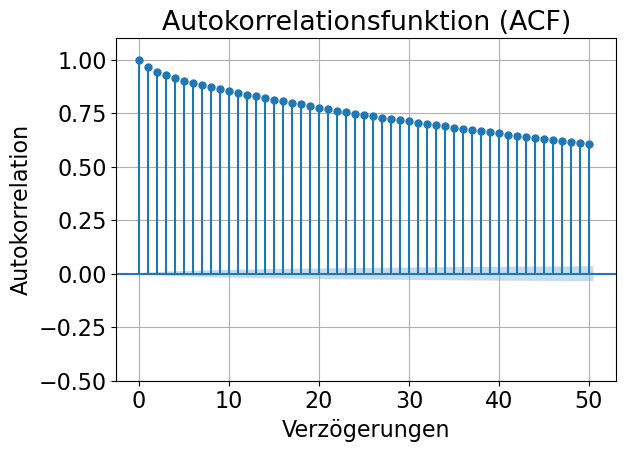

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# ACF-Plot
plt.figure(figsize=(12, 5))
acf_plot = plot_acf(df_train["Power (kW)"], lags=50, title="Autokorrelationsfunktion (ACF)")
plt.xlabel("Verzögerungen")
plt.ylabel("Autokorrelation")

plt.ylim(-0.5, 1.1)
plt.grid(True)
plt.rcParams.update({'font.size': 16})
plt.tight_layout()
plt.show()

<Figure size 1200x500 with 0 Axes>

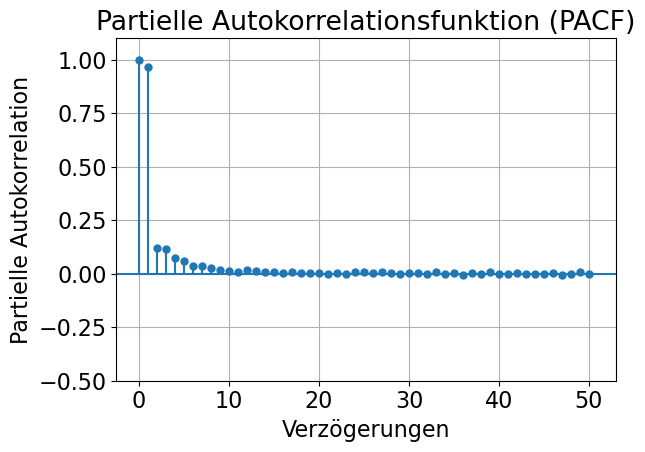

In [14]:
# PACF-Plot
plt.figure(figsize=(12, 5))
pacf_plot = plot_pacf(df_train["Power (kW)"], lags=50, title="Partielle Autokorrelationsfunktion (PACF)")
plt.xlabel("Verzögerungen")
plt.ylabel("Partielle Autokorrelation")

# Lags und Zeitformat

plt.ylim(-0.5, 1.1)
plt.grid(True)
plt.rcParams.update({'font.size': 16})
plt.tight_layout()
plt.show()

In [8]:
auto_arima_model = auto_arima(df_train["Power (kW)"].iloc[-144:], seasonal=False, trace=True, suppress_warnings=True, stepwise=False, m=1)
p, d, q = auto_arima_model.order

print(auto_arima_model.summary)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2385.466, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2227.383, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2141.156, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2090.889, Time=0.13 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2065.565, Time=0.20 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1965.156, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1967.093, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1963.464, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1964.517, Time=0.08 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1965.673, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1967.116, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1967.864, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1962.725, Time=0.09 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1962.991, Time=0.14 sec
 ARIMA(3,0,0)(0

In [151]:
print(auto_arima_model.summary)

<bound method ARIMA.summary of ARIMA(order=(2, 1, 0), scoring_args={}, suppress_warnings=True)>


In [16]:
def check_stationarity(series):
    result = adfuller(series)
    print(f"p-Wert: {result[1]} (stationär, wenn < 0.05)")

check_stationarity(df_train["Power (kW)"].iloc[-144:])

p-Wert: 0.003651365591125529 (stationär, wenn < 0.05)


In [10]:
arima = ARIMA(df_train["Power (kW)"].iloc[-144:], order=auto_arima_model.order)
arima_fit = arima.fit()

/Users/philneuburger/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/philneuburger/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/philneuburger/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


In [17]:
import pickle

with open('arima_model.pkl', 'wb') as file:
    pickle.dump(arima_fit, file)

In [12]:
forecasts = arima_fit.get_forecast(steps=144)

In [13]:
actual_values = df_val["Power (kW)"].iloc[:144]

mae = mean_absolute_error(actual_values, forecasts.predicted_mean)
rmse = root_mean_squared_error(actual_values, forecasts.predicted_mean)

print("Vorhersagen:", forecasts.predicted_mean)
print("Tatsächliche Werte:", actual_values.values)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Vorhersagen: 2019-07-01 00:00:00    752.570853
2019-07-01 00:10:00    775.305789
2019-07-01 00:20:00    790.699378
2019-07-01 00:30:00    803.322726
2019-07-01 00:40:00    814.036180
                          ...    
2019-07-01 23:10:00    876.691736
2019-07-01 23:20:00    876.691736
2019-07-01 23:30:00    876.691736
2019-07-01 23:40:00    876.691736
2019-07-01 23:50:00    876.691736
Freq: 10min, Name: predicted_mean, Length: 144, dtype: float64
Tatsächliche Werte: [ 754.91183793  902.666745   1004.91525574 1059.45250549 1206.27666626
 1470.51073608 1414.05595093 1505.79920044 1630.50145874 1367.16690063
 1182.78891296 1127.38520813 1237.7401947  1197.78763123 1111.88391724
  958.68509827  866.10918226  824.7713562   906.92060547  885.42932129
  860.17079163  977.8144165   777.3988519   760.53552246  724.26167297
  964.6393219   740.30769501  662.35843506  758.69111633  802.89703979
  675.50202179  744.78295898  546.63819733  703.78571014 1034.73389893
 1116.17637233 1060.50466309  751

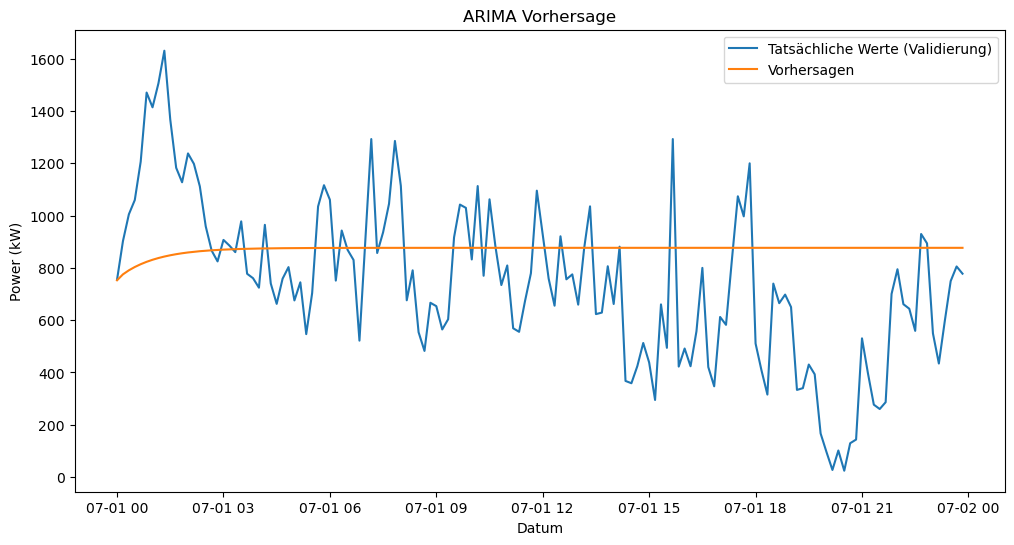

In [14]:
horizon = 144

plt.figure(figsize=(12, 6))
plt.title("ARIMA Vorhersage")
plt.plot(df_val.index[:horizon], df_val["Power (kW)"].iloc[:horizon], label="Tatsächliche Werte (Validierung)")
plt.plot(df_val.index[:horizon], forecasts.predicted_mean[:horizon], label="Vorhersagen")
plt.ylabel("Power (kW)")
plt.xlabel("Datum")
plt.legend()
plt.show()

## Ein Tages Vorhersage mit ARIMA

In [18]:
sarima_modell = SARIMAX(df_train["Power (kW)"].iloc[-144:], order=(2,0,2), seasonal_order=(1,1,1,144))
fit = sarima_modell.fit()

/Users/philneuburger/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/philneuburger/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [19]:
forecasts = fit.get_forecast(steps=144)

In [20]:
forecasts.predicted_mean

2019-07-01 00:00:00    1201.089636
2019-07-01 00:10:00    1402.001862
2019-07-01 00:20:00    1929.875098
2019-07-01 00:30:00    1781.654965
2019-07-01 00:40:00    1510.262714
                          ...     
2019-07-01 23:10:00     661.637636
2019-07-01 23:20:00     779.790227
2019-07-01 23:30:00     703.556299
2019-07-01 23:40:00     744.442578
2019-07-01 23:50:00     735.351937
Freq: 10min, Name: predicted_mean, Length: 144, dtype: float64

In [21]:
actual_values = df_val["Power (kW)"].iloc[:144]

mae = mean_absolute_error(actual_values, forecasts.predicted_mean)
rmse = root_mean_squared_error(actual_values, forecasts.predicted_mean)

print("Vorhersagen:", forecasts.predicted_mean)
print("Tatsächliche Werte:", actual_values.values)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Vorhersagen: 2019-07-01 00:00:00    1201.089636
2019-07-01 00:10:00    1402.001862
2019-07-01 00:20:00    1929.875098
2019-07-01 00:30:00    1781.654965
2019-07-01 00:40:00    1510.262714
                          ...     
2019-07-01 23:10:00     661.637636
2019-07-01 23:20:00     779.790227
2019-07-01 23:30:00     703.556299
2019-07-01 23:40:00     744.442578
2019-07-01 23:50:00     735.351937
Freq: 10min, Name: predicted_mean, Length: 144, dtype: float64
Tatsächliche Werte: [ 754.91183793  902.666745   1004.91525574 1059.45250549 1206.27666626
 1470.51073608 1414.05595093 1505.79920044 1630.50145874 1367.16690063
 1182.78891296 1127.38520813 1237.7401947  1197.78763123 1111.88391724
  958.68509827  866.10918226  824.7713562   906.92060547  885.42932129
  860.17079163  977.8144165   777.3988519   760.53552246  724.26167297
  964.6393219   740.30769501  662.35843506  758.69111633  802.89703979
  675.50202179  744.78295898  546.63819733  703.78571014 1034.73389893
 1116.17637233 1060.50

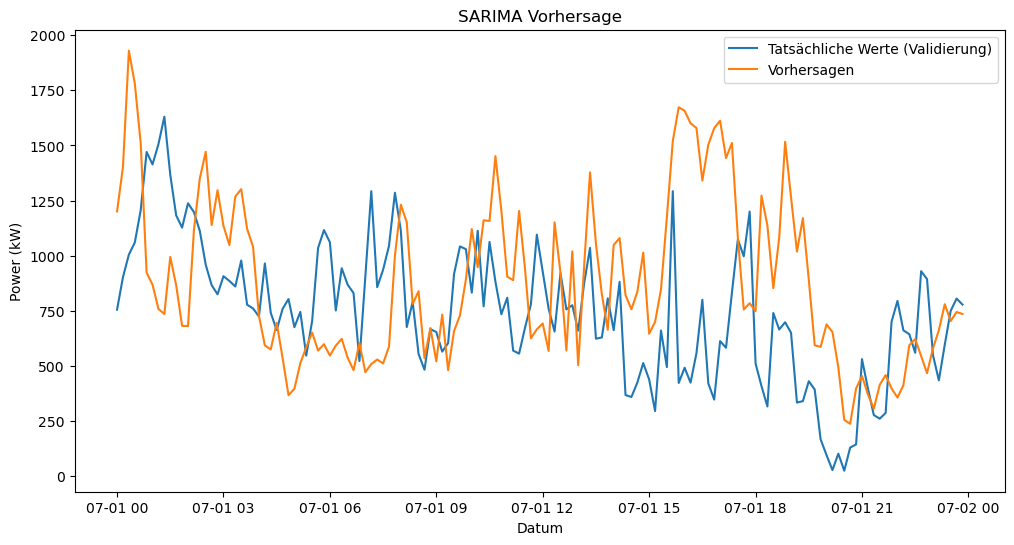

In [22]:
plt.figure(figsize=(12, 6))
plt.title("SARIMA Vorhersage")
plt.plot(df_val.index[:144], df_val["Power (kW)"].iloc[:144], label="Tatsächliche Werte (Validierung)")
plt.plot(df_val.index[:144], forecasts.predicted_mean[:144], label="Vorhersagen")
plt.ylabel("Power (kW)")
plt.xlabel("Datum")
plt.legend()
plt.show()

## SARIMAX Vorhersage mit exogenen Variablen

In [6]:
df_exog = df_train[["Wind speed (m/s)"]]

In [35]:
arima_model = SARIMAX(df_train["Power (kW)"], order=auto_arima_model.order, seasonal_order=(0,0,0,0), exog=df_train["Wind speed (m/s)"])
model_fit = arima_model.fit()

/Users/philneuburger/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/philneuburger/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.98177D+00    |proj g|=  2.51090D-01


 This problem is unconstrained.



At iterate    5    f=  5.93191D+00    |proj g|=  1.84245D-02

At iterate   10    f=  5.93131D+00    |proj g|=  7.55823D-04

At iterate   15    f=  5.93120D+00    |proj g|=  1.36087D-02

At iterate   20    f=  5.92904D+00    |proj g|=  1.88614D-02

At iterate   25    f=  5.92668D+00    |proj g|=  8.13619D-03

At iterate   30    f=  5.92236D+00    |proj g|=  4.03339D-03

At iterate   35    f=  5.92189D+00    |proj g|=  3.27198D-04

At iterate   40    f=  5.92177D+00    |proj g|=  1.16219D-03

At iterate   45    f=  5.92150D+00    |proj g|=  7.76226D-04

At iterate   50    f=  5.92147D+00    |proj g|=  1.04626D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/philneuburger/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
import pickle

with open('sarimax_model.pkl', 'wb') as file:
    pickle.dump(model_fit, file)

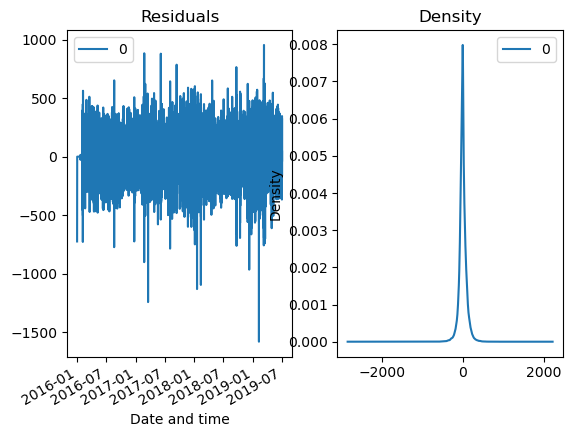

In [37]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [38]:
model_fit.aic

1055609.5132256034

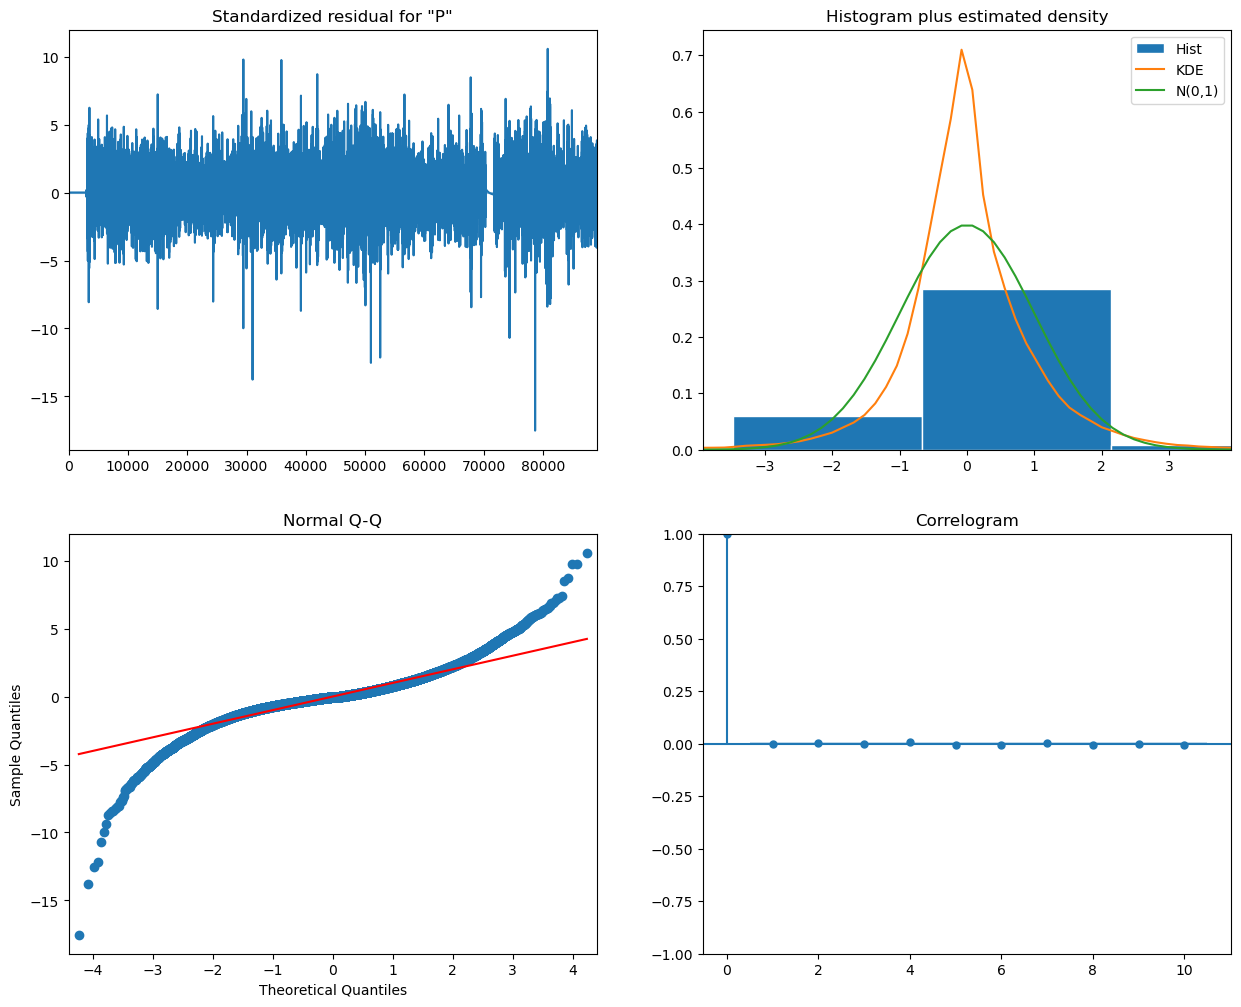

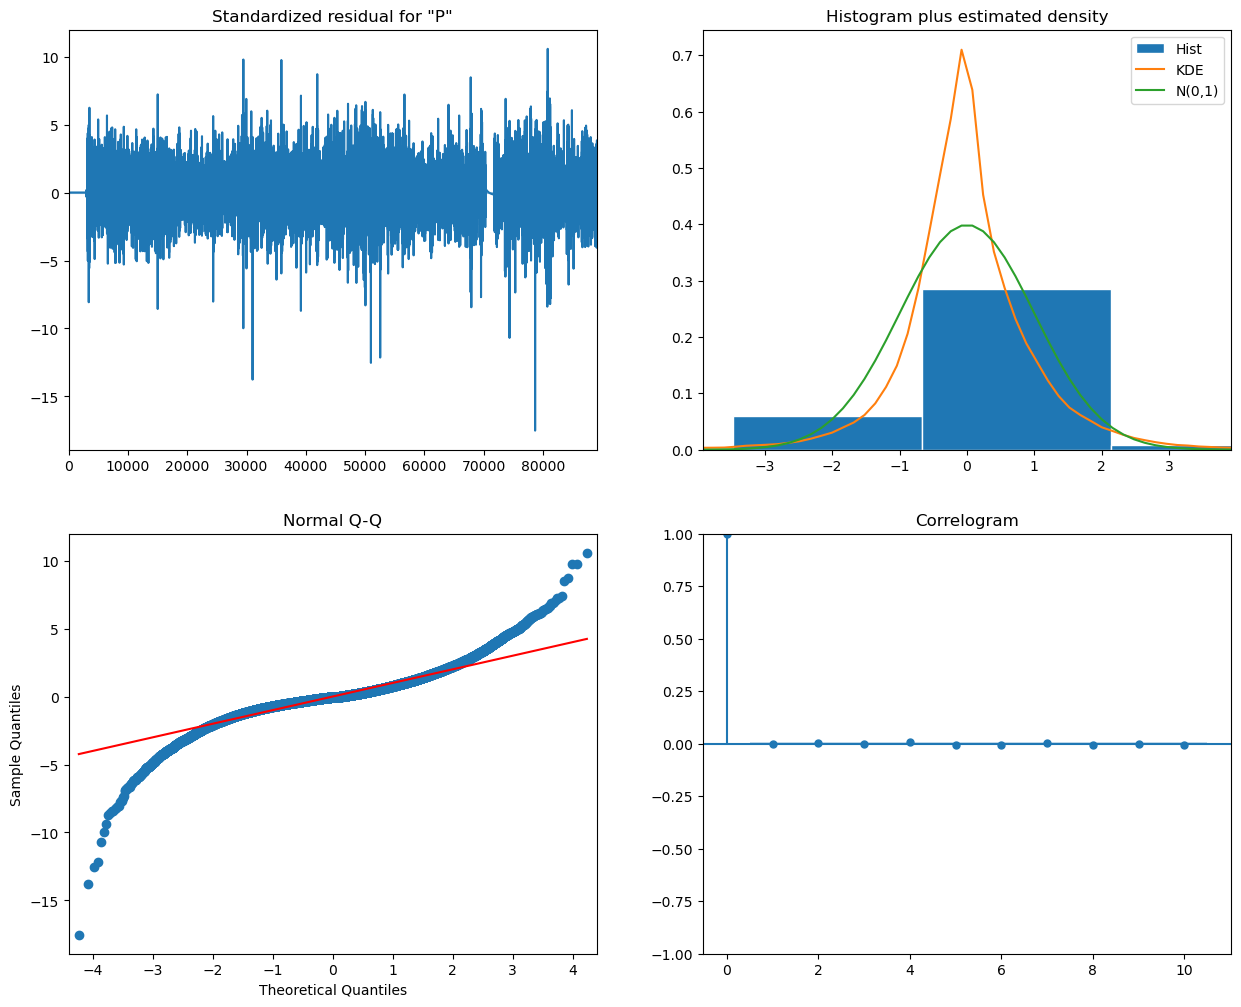

In [39]:
model_fit.plot_diagnostics(figsize=(15,12))

In [40]:
df_train.describe()

,Density adjusted wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Wind speed (m/s)
count,89133.000000,89133.000000,89133.000000,89133.000000,89133.000000
mean,5.781048,207.549769,207.193839,567.603092,5.762554
std,2.658992,95.877442,95.051161,587.034297,2.771344
min,0.110012,0.021184,0.011559,0.000000,0.110653
25%,3.840842,136.058243,138.853638,98.371902,3.694353
50%,5.912163,236.570679,236.210358,377.136749,5.680080
75%,7.150623,275.881958,268.365997,827.820496,7.350000
max,21.799972,359.998779,359.969177,2081.028912,21.875542


In [41]:
forecast = model_fit.get_forecast(steps=144, exog=df_val["Wind speed (m/s)"].iloc[:144])
forecast_ci = forecast.conf_int()

/Users/philneuburger/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [42]:
forecast_ci

,lower Power (kW),upper Power (kW)
89133,599.760009,953.802610
89134,643.133478,1072.924776
89135,684.357132,1157.985815
89136,682.079684,1187.873580
89137,762.004974,1293.826341
...,...,...
89272,276.769710,1002.256728
89273,452.352993,1177.865467
89274,481.212687,1206.750580
89275,562.436266,1287.999545


In [43]:
actual_values = df_val["Power (kW)"].iloc[:144]

In [44]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

mae = mean_absolute_error(actual_values, forecast.predicted_mean)
rmse = root_mean_squared_error(actual_values, forecast.predicted_mean)

print("Vorhersagen:", forecast.predicted_mean)
print("Tatsächliche Werte:", actual_values.values)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)


Vorhersagen: 89133     776.781310
89134     858.029127
89135     921.171473
89136     934.976632
89137    1027.915657
            ...     
89272     639.513219
89273     815.109230
89274     843.981633
89275     925.217906
89276     893.508267
Name: predicted_mean, Length: 144, dtype: float64
Tatsächliche Werte: [ 754.91183793  902.666745   1004.91525574 1059.45250549 1206.27666626
 1470.51073608 1414.05595093 1505.79920044 1630.50145874 1367.16690063
 1182.78891296 1127.38520813 1237.7401947  1197.78763123 1111.88391724
  958.68509827  866.10918226  824.7713562   906.92060547  885.42932129
  860.17079163  977.8144165   777.3988519   760.53552246  724.26167297
  964.6393219   740.30769501  662.35843506  758.69111633  802.89703979
  675.50202179  744.78295898  546.63819733  703.78571014 1034.73389893
 1116.17637233 1060.50466309  751.36677399  942.86207886  868.62409058
  830.27316589  521.72621235  906.8357666  1292.6658844   857.01495285
  936.09901276 1044.96705387 1285.41410828 1113

In [45]:
df_train

,Density adjusted wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Wind speed (m/s)
Date and time,,,,,
2016-01-03 00:00:00,6.401065,275.881958,268.365997,583.140015,6.730000
2016-01-03 00:10:00,6.401065,275.881958,268.365997,583.140015,6.730000
2016-01-03 00:20:00,6.401065,275.881958,268.365997,583.140015,6.730000
2016-01-03 00:30:00,6.401065,275.881958,268.365997,583.140015,6.730000
2016-01-03 00:40:00,6.401065,275.881958,268.365997,583.140015,6.730000
...,...,...,...,...,...
2019-06-30 22:40:00,6.199621,241.814894,229.951508,544.928223,6.259876
2019-06-30 23:00:00,6.410535,232.282736,229.951508,578.759598,6.470486
2019-06-30 23:20:00,7.063978,240.201382,232.252244,779.790227,7.126949


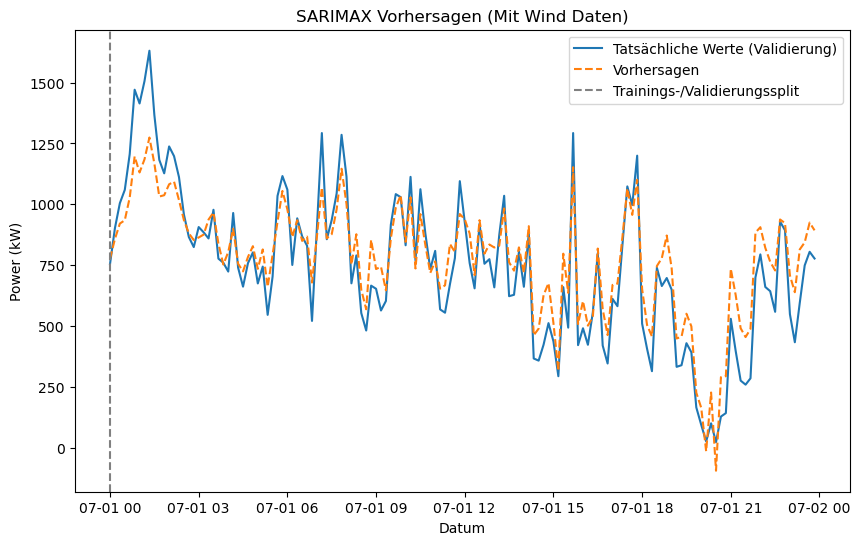

In [46]:
plt.figure(figsize=(10, 6))
plt.title("SARIMAX Vorhersagen (Mit Wind Daten)")
plt.plot(df_val.index[:144], actual_values[:144], label="Tatsächliche Werte (Validierung)")
plt.plot(df_val.index[:144], forecast.predicted_mean[:144], label="Vorhersagen", linestyle="--")
plt.axvline(x=df_val.index[0], color="gray", linestyle="--", label="Trainings-/Validierungssplit")
plt.ylabel("Power (kW)")
plt.xlabel("Datum")
plt.legend()
plt.show()

In [54]:
pred = model_fit.get_prediction(start=pd.to_datetime("2019-06-30 23:00:00"), dynamic=False)

In [55]:
pred.predicted_mean

2019-06-30 23:00:00    508.771240
2019-06-30 23:10:00    663.410207
2019-06-30 23:20:00    667.710000
2019-06-30 23:30:00    726.324331
2019-06-30 23:40:00    687.637468
2019-06-30 23:50:00    769.834445
Freq: 10min, Name: predicted_mean, dtype: float64

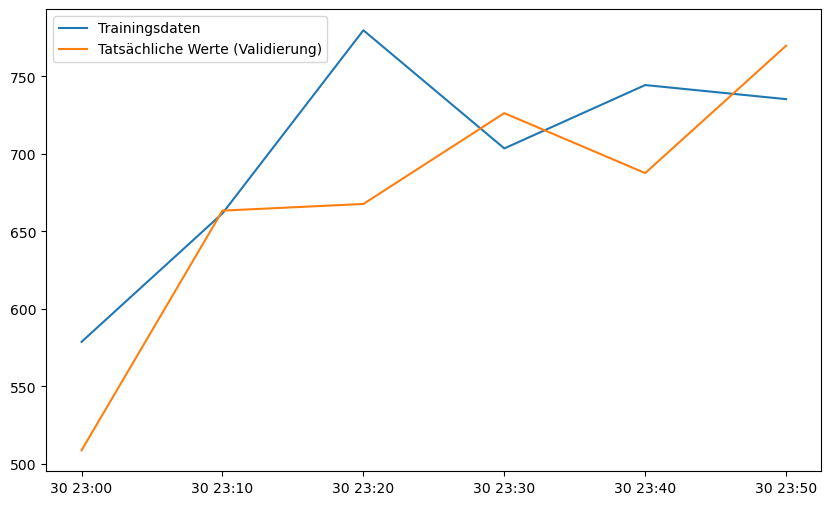

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(df_train.index[-6:], df_train["Power (kW)"].iloc[-6:], label="Trainingsdaten")
plt.plot(df_train.index[-6:], pred.predicted_mean, label="Tatsächliche Werte (Validierung)")
plt.legend()
plt.show()

In [61]:
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(actual_values, forecast.predicted_mean)

print("Vorhersagen:", pred.predicted_mean)
print("Tatsächliche Werte:", df_train["Power (kW)"].iloc[-6:])
print("Root Mean Squared Error (RMSE):", rmse)


Vorhersagen: 2019-06-30 23:00:00    508.771240
2019-06-30 23:10:00    663.410207
2019-06-30 23:20:00    667.710000
2019-06-30 23:30:00    726.324331
2019-06-30 23:40:00    687.637468
2019-06-30 23:50:00    769.834445
Freq: 10min, Name: predicted_mean, dtype: float64
Tatsächliche Werte: Date and time
2019-06-30 23:00:00    578.759598
2019-06-30 23:10:00    661.637636
2019-06-30 23:20:00    779.790227
2019-06-30 23:30:00    703.556299
2019-06-30 23:40:00    744.442578
2019-06-30 23:50:00    735.351937
Name: Power (kW), dtype: float64
Root Mean Squared Error (RMSE): 331.4136396497173


# VAR

In [81]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [90]:
train = df_train
val = df_val.iloc[:10]

In [91]:
train['month'] = df_train.index.month
train['weekday'] = df_train.index.day_of_week
train['day_of_year'] = df_train.index.day_of_year
train['year'] = df_train.index.year
train['hour'] = df_train.index.hour
train['minute'] = df_train.index.minute

In [92]:
train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)
train['day_sin'] = np.sin(2 * np.pi * train['day_of_year'] / 365)
train['day_cos'] = np.cos(2 * np.pi * train['day_of_year'] / 365)

In [94]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series)
    print(f"p-Wert: {result[1]} (stationär, wenn < 0.05)")

check_stationarity(train["Power (kW)"])

KeyboardInterrupt: 

In [95]:
train_diff = train.diff().dropna()

In [96]:
model_var = VAR(train_diff)

In [97]:
results = model_var.fit(maxlags=10, ic='aic')

In [98]:
forecast_diff = results.forecast(train_diff.values[-results.k_ar:], steps=10)

In [99]:
forecast_val = pd.DataFrame(forecast_diff, index=val.index, columns=train.columns)
forecast_val = forecast_val.cumsum() + train.iloc[-1]

In [100]:
mae = mean_absolute_error(val["Power (kW)"], forecast_val["Power (kW)"])
print("Mean Absolute Error (MAE):", mae)
print("Vorhersagen:", forecast_val["Power (kW)"])
print("Tatsächliche Werte:", actual_values.values)

Mean Absolute Error (MAE): 511.3842763955995
Vorhersagen: Date and time
2019-07-01 00:00:00    721.976614
2019-07-01 00:10:00    716.658882
2019-07-01 00:20:00    716.334953
2019-07-01 00:30:00    720.284231
2019-07-01 00:40:00    720.583693
2019-07-01 00:50:00    721.394298
2019-07-01 01:00:00    722.714550
2019-07-01 01:10:00    721.201711
2019-07-01 01:20:00    721.055950
2019-07-01 01:30:00    720.209611
Name: Power (kW), dtype: float64
Tatsächliche Werte: [ 754.91183793  902.666745   1004.91525574 1059.45250549 1206.27666626
 1470.51073608 1414.05595093 1505.79920044 1630.50145874 1367.16690063]


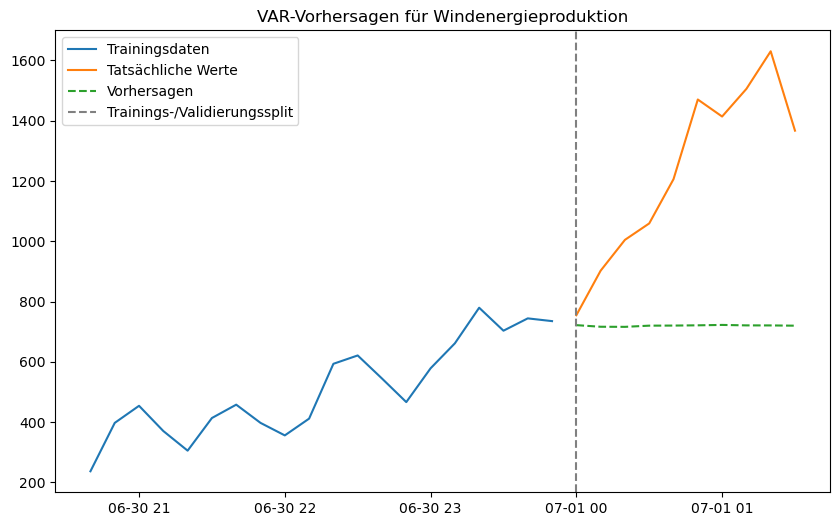

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(train.index[-20:], train["Power (kW)"].iloc[-20:], label="Trainingsdaten")
plt.plot(val.index, val["Power (kW)"], label="Tatsächliche Werte")
plt.plot(val.index, forecast_val["Power (kW)"], label="Vorhersagen", linestyle="--")
plt.axvline(x=val.index[0], color="gray", linestyle="--", label="Trainings-/Validierungssplit")
plt.legend()
plt.title("VAR-Vorhersagen für Windenergieproduktion")
plt.show()

In [46]:
from statsmodels.tsa.api import VAR
import numpy as np
import pandas as pd

# 1. Rollierende Vorhersagen konfigurieren
forecast_horizon = 10  # Vorhersagezeitraum (10 Schritte)
initial_train_size = 183300  # Initiale Größe des Trainingsdatensatzes
rolling_forecasts = []  # Speichert die Vorhersagen
actual_values = []  # Speichert die tatsächlichen Werte

# 2. Rollierende Vorhersage
for start in range(initial_train_size, len(df_train) - forecast_horizon + 1, forecast_horizon):
    # Trainingsdaten aktualisieren (Mehrere Zeitreihen berücksichtigen)
    train_data = df_train.iloc[:start]
    
    # VAR-Modell trainieren
    model = VAR(train_data)
    results = model.fit(maxlags=15, ic='aic')  # Wählen Sie die optimale Verzögerung
    
    # Vorhersage für den nächsten Zeitraum
    forecast = results.forecast(y=train_data.values[-results.k_ar:], steps=forecast_horizon)
    
    # Speichere Vorhersagen und tatsächliche Werte
    rolling_forecasts.extend(forecast[:, 3])  # Vorhersagen für "Power (kW)" (erste Spalte)
    actual_values.extend(df_train["Power (kW)"].iloc[start:start + forecast_horizon].values)

last_original_value = df_train["Power (kW)"].iloc[initial_train_size - 1]

reconstructed_forecasts = []
current_value = last_original_value

for forecast in rolling_forecasts:
    current_value += forecast  # Addiere die Differenz zur letzten Vorhersage
    reconstructed_forecasts.append(current_value)


# 3. Evaluierung der rollierenden Vorhersage
errors = [actual - predicted for actual, predicted in zip(actual_values, rolling_forecasts)]

# Berechnung von MAE und RMSE
mae = np.mean([abs(e) for e in errors])
rmse = np.sqrt(np.mean([e**2 for e in errors]))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

/Users/philneuburger/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/philneuburger/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/philneuburger/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/philneuburger/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/philneuburger/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.

Mean Absolute Error (MAE): 216.7020445462287
Root Mean Squared Error (RMSE): 307.2162034634932


In [47]:
rolling_forecasts

[254.77522252835925,
 252.93932124615796,
 253.93707302954257,
 258.66538898591574,
 262.4509107476537,
 264.04869642489524,
 269.3735658954679,
 272.59283545651425,
 275.53461856455147,
 280.9431854604482,
 234.58781773350375,
 241.54501451159453,
 245.44941350708982,
 249.52213350257497,
 251.99224430901768,
 258.5002817205225,
 262.6694235274033,
 265.1455393653096,
 269.7221828848107,
 271.71900868603205,
 64.27505718195027,
 73.57051521576429,
 79.32908642170761,
 87.48482641646297,
 93.65624038556233,
 97.13882700729755,
 103.29478449464443,
 109.16549698391367,
 113.41275814120921,
 118.36707340022413,
 114.45985777109915,
 118.39296013562702,
 123.09850082599802,
 125.73662495358724,
 130.56874212921076,
 135.926048469747,
 140.16835912364482,
 144.44681772611227,
 149.5849553761595,
 153.79330970352405,
 67.96146652884816,
 77.68042779783946,
 83.60953915694381,
 88.46342689346243,
 93.09498119116988,
 97.91732245965913,
 102.32465861085464,
 106.31806423020004,
 110.514522119

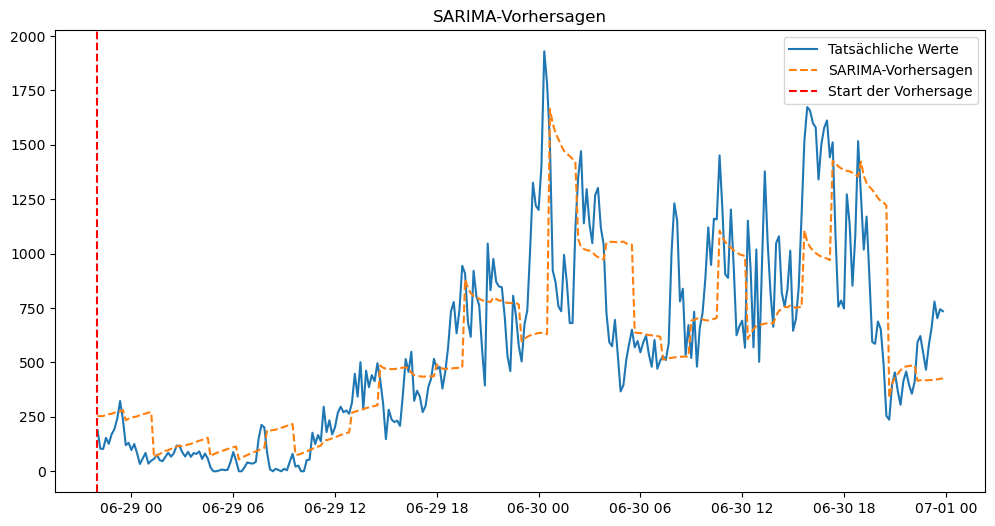

In [48]:
# Plot der Ergebnisse
plt.figure(figsize=(12, 6))
plt.plot(df_train.index[initial_train_size:initial_train_size + len(rolling_forecasts)], df_train["Power (kW)"].iloc[initial_train_size:initial_train_size + len(rolling_forecasts)], label="Tatsächliche Werte")
plt.plot(df_train.index[initial_train_size:initial_train_size + len(rolling_forecasts)], rolling_forecasts, label="SARIMA-Vorhersagen", linestyle="--")
plt.axvline(x=df_train.index[initial_train_size], color="red", linestyle="--", label="Start der Vorhersage")
plt.legend()
plt.title("SARIMA-Vorhersagen")
plt.show()

In [49]:
group_size = 10
num_groups = len(actual_values) // group_size

# Ergebnisse speichern
results = []

# Berechnung der Genauigkeit für jeden Schritt innerhalb der Gruppen
for i in range(num_groups):
    # Slice für die aktuelle Gruppe
    start = i * group_size
    end = start + group_size
    actual_group = actual_values[start:end]
    predicted_group = rolling_forecasts[start:end]
    
    # Ergebnisse für jeden Schritt
    for step in range(group_size):
        actual_value = actual_group[step]
        predicted_value = predicted_group[step]
        
        # RMSE und prozentuale Abweichung berechnen
        rmse = np.sqrt((actual_value - predicted_value) ** 2)
        percentage_error = abs(actual_value - predicted_value) / actual_value * 100
        
        # Ergebnis speichern
        results.append({
            "Group": i + 1,
            "Step": step + 1,
            "Actual Value": actual_value,
            "Predicted Value": predicted_value,
            "RMSE": rmse,
            "Prozentualer Fehler (%)": percentage_error
        })

# Ergebnisse in eine Tabelle umwandeln
accuracy_table = pd.DataFrame(results)

In [53]:
accuracy_table = accuracy_table[:220]

In [54]:
accuracy_table[accuracy_table["Step"] == 1]

,Group,Step,Actual Value,Predicted Value,RMSE,Prozentualer Fehler (%)
0,1,1,188.737481,254.775223,66.037742,34.989204
10,2,1,120.075479,234.587818,114.512339,95.366964
20,3,1,57.077899,64.275057,7.197159,12.609362
30,4,1,86.893963,114.459858,27.565895,31.723602
40,5,1,17.159319,67.961467,50.802148,296.061564
50,6,1,0.000000,54.113888,54.113888,inf
60,7,1,84.411602,189.750983,105.339381,124.792538
70,8,1,21.598598,76.605168,55.006570,254.676581
80,9,1,296.503848,138.664460,157.839388,53.233504
90,10,1,315.686485,269.285984,46.400501,14.698286


In [55]:
# Durchschnittlichen RMSE für jeden Schritt berechnen
average_rmse_per_step = accuracy_table.groupby("Step")["RMSE"].mean().reset_index()

# Tabelle anzeigen
average_rmse_per_step.rename(columns={"RMSE": "Average RMSE"}, inplace=True)

# Ausgabe der Tabelle
print(average_rmse_per_step)

   Step  Average RMSE
0     1     95.878770
1     2    141.398558
2     3    159.078945
3     4    170.730941
4     5    187.246747
5     6    213.981023
6     7    233.243473
7     8    216.901484
8     9    223.907516
9    10    200.627680


# GAM

In [112]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

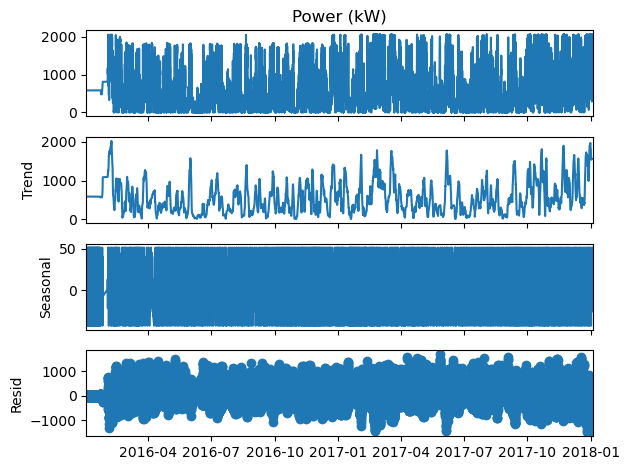

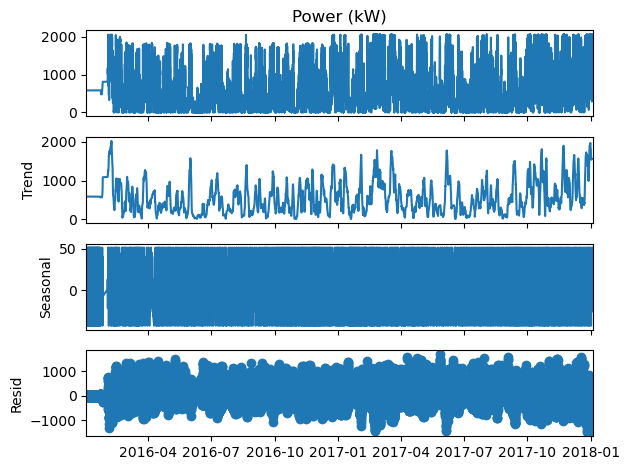

In [114]:
data = df_train["Power (kW)"].iloc[:50000]
decomposition = seasonal_decompose(data, model="additive", period=144)
decomposition.plot()

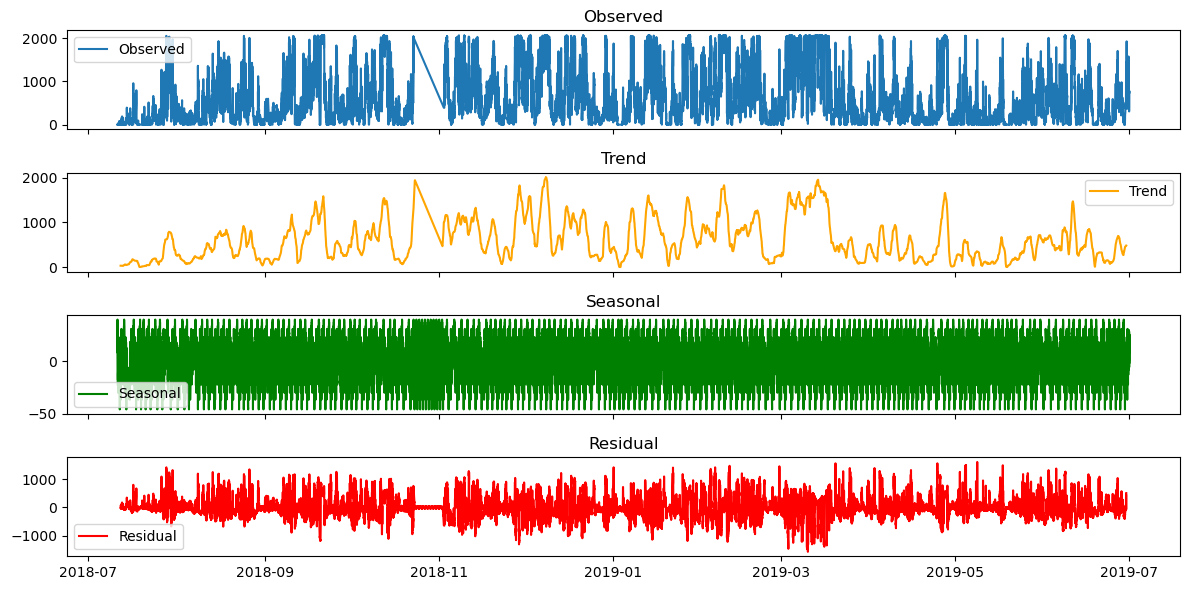

In [111]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

data = df_train["Power (kW)"].iloc[-26200:]
decomposition = seasonal_decompose(data, model="additive", period=144)

# Figurengröße anpassen und die Komponenten manuell plotten
fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)  # 4 Subplots in einer Spalte

# Komponenten einzeln plotten
axes[0].plot(decomposition.observed, label="Observed")
axes[0].set_title("Observed")
axes[0].legend()

axes[1].plot(decomposition.trend, label="Trend", color="orange")
axes[1].set_title("Trend")
axes[1].legend()

axes[2].plot(decomposition.seasonal, label="Seasonal", color="green")
axes[2].set_title("Seasonal")
axes[2].legend()

axes[3].plot(decomposition.resid, label="Residual", color="red")
axes[3].set_title("Residual")
axes[3].legend()

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

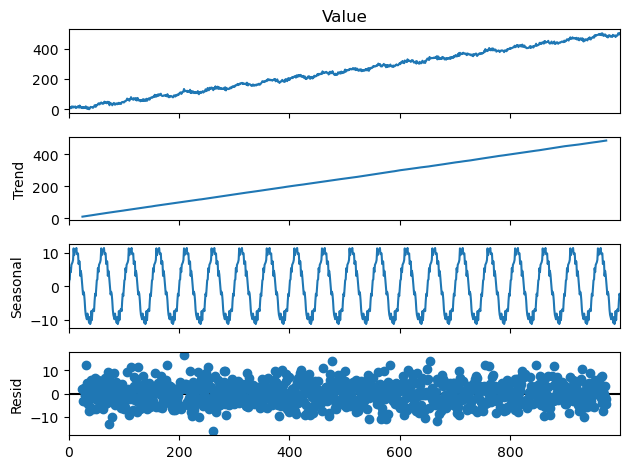

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Generiere saisonale Daten
np.random.seed(42)
n = 1000  # Anzahl der Datenpunkte
time = np.arange(n)
trend = time * 0.5  # Linearer Trend
seasonal = 10 * np.sin(2 * np.pi * time / 50)  # Saisonalität mit Periode 50
noise = np.random.normal(scale=5, size=n)  # Zufälliges Rauschen
data = trend + seasonal + noise

# In einen DataFrame packen
df_seasonal = pd.DataFrame({"Time": time, "Value": data})

# Seasonal Decompose auf die saisonalen Daten anwenden
decomposition_seasonal = seasonal_decompose(df_seasonal["Value"], model="additive", period=50)

# Plot der Decomposition
fig = decomposition_seasonal.plot()
plt.show()

## Vorhersage mit Winddaten

In [20]:
gam = GAM(s(0))

In [21]:
train_size = 183000
forecast_size = 144

#X_train = df_gam.iloc[:train_size].values
#X_test = df_gam.iloc[train_size:train_size + forecast_size].values
X_train = df_train["Wind speed (m/s)"].iloc[:train_size].values
X_test = df_val["Wind speed (m/s)"].iloc[:forecast_size].values

y_train = df_train["Power (kW)"].iloc[:train_size].values
y_test = df_val["Power (kW)"].iloc[:forecast_size].values


In [22]:
gam.gridsearch(X_train, y_train)

ValueError: not enough values to unpack (expected 2, got 1)

In [25]:
gam_fit = gam.fit(X_train, y_train)

In [26]:
import pickle

with open('gam_model.pkl', 'wb') as file:
    pickle.dump(gam_fit, file)

In [24]:
y_pred = gam.predict(X_test)

gam_mse = mean_squared_error(y_test, y_pred)
gam_mae = mean_absolute_error(y_test, y_pred)
gam_rmse = root_mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {gam_mse}')
print(f'Mean Absolute Error: {gam_mae}')
print(f'Root Mean Squared Error: {gam_rmse}')

Mean Squared Error: 4664.205451885716
Mean Absolute Error: 55.31478941927104
Root Mean Squared Error: 68.29498848294593


In [46]:
y_test

array([ 754.91183793,  902.666745  , 1004.91525574, 1059.45250549,
       1206.27666626, 1470.51073608, 1414.05595093, 1505.79920044,
       1630.50145874, 1367.16690063, 1182.78891296, 1127.38520813,
       1237.7401947 , 1197.78763123, 1111.88391724,  958.68509827,
        866.10918226,  824.7713562 ,  906.92060547,  885.42932129,
        860.17079163,  977.8144165 ,  777.3988519 ,  760.53552246,
        724.26167297,  964.6393219 ,  740.30769501,  662.35843506,
        758.69111633,  802.89703979,  675.50202179,  744.78295898,
        546.63819733,  703.78571014, 1034.73389893, 1116.17637233,
       1060.50466309,  751.36677399,  942.86207886,  868.62409058,
        830.27316589,  521.72621235,  906.8357666 , 1292.6658844 ,
        857.01495285,  936.09901276, 1044.96705387, 1285.41410828,
       1113.51064758,  676.0350296 ,  790.56920319,  554.01006012,
        482.34017114,  666.55737125,  653.57966614,  564.48695775,
        603.5146902 ,  916.61123818, 1042.05076904, 1029.50366

In [11]:
y_pred

array([ 754.42455272,  898.15034435, 1013.1645927 , 1035.82273245,
       1211.60974889, 1529.61779131, 1403.31668428, 1500.99485062,
       1655.79555768, 1463.69909111, 1198.90650819, 1206.52668301,
       1291.29276808, 1309.74197579, 1159.7678721 ,  999.86063313,
        897.47742717,  846.03054067,  862.92504141,  882.36791874,
        994.65873328, 1047.89083063,  813.170878  ,  669.55417689,
        751.57823035,  918.02457053,  671.46387246,  622.7620097 ,
        713.54517515,  786.59506213,  635.93348692,  762.49373392,
        530.47753447,  724.3990945 ,  963.10874359, 1203.9536817 ,
       1056.55177343,  846.01780767,  971.17980378,  817.27041758,
        847.46098741,  549.72198294,  849.17381597, 1226.8178589 ,
        833.18037884,  862.68039917, 1051.75232497, 1374.16435276,
       1092.77120369,  653.33382828,  860.78833193,  508.58120745,
        414.68771141,  819.71155729,  624.68165874,  639.26905471,
        504.6934253 ,  829.10885803, 1060.66375584, 1160.35712

In [12]:
error = []

i = 0
for y in y_pred:
    
    e = y_test[i] - y
    e = np.sqrt(e**2)
    error.append(e)
    i += 1


In [13]:
print(error)

[0.48728520622955784, 4.516400645569661, 8.249336964036502, 23.62977304662286, 5.333082633480899, 59.107055228188756, 10.739266650094578, 4.804349820074776, 25.294098942369146, 96.53219047677044, 16.11759522330999, 79.14147488453841, 53.5525733814618, 111.95434456106, 47.88395486079139, 41.175534863048824, 31.368244915611854, 21.259184468427065, 43.99556405645649, 3.061402549573586, 134.4879416537218, 70.07641413098884, 35.772026101757206, 90.9813455737634, 27.31655737426854, 46.61475136860474, 68.84382254351567, 39.5964253587058, 45.1459411877247, 16.30197766422475, 39.568534869509676, 17.710774938294662, 16.160662861264996, 20.61338435636719, 71.62515533149167, 87.77730937129695, 3.9528896564295337, 94.6510336785966, 28.317724926362757, 51.353672997174726, 17.187821514531947, 27.995770593901057, 57.66195063281327, 65.84802550077143, 23.834574009752487, 73.41861358161782, 6.785271106650498, 88.75024448189083, 20.739443894614624, 22.701201319395636, 70.21912874040663, 45.42885266594521

In [14]:
errors

NameError: name 'errors' is not defined

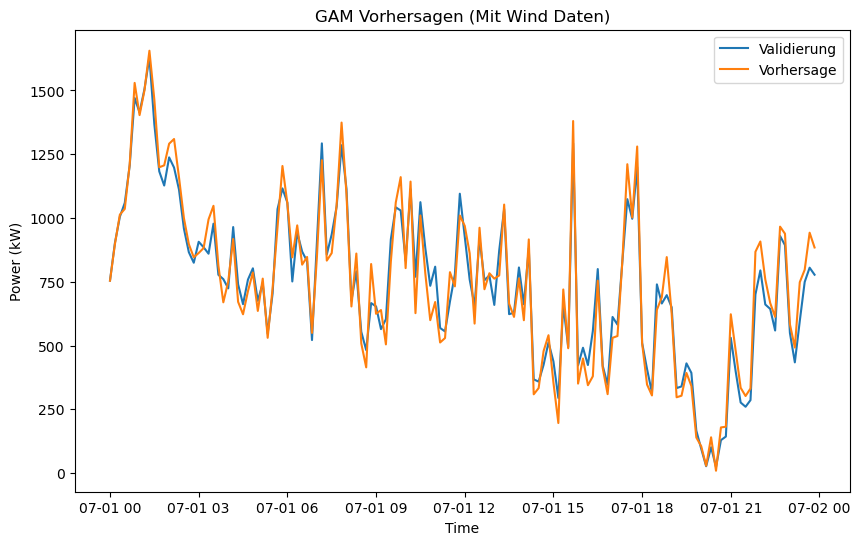

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(df_val.index[:forecast_size], y_test, label="Validierung")
plt.plot(df_val.index[:forecast_size], y_pred, label="Vorhersage")
plt.title("GAM Vorhersagen (Mit Wind Daten)")
plt.ylabel("Power (kW)")
plt.xlabel("Time")
plt.legend()
plt.show()

## Vorhersage ohne Winddaten

In [184]:
gam = LinearGAM(s(0, lam=0.8))

In [185]:
df_gam = pd.DataFrame()
df_gam['time'] = np.arange(len(df_train))

#df_gam['time_scaled'] = (df_gam['time'] - df_gam['time'].min()) / \
                            #(df_gam['time'].max() - df_gam['time'].min())

df_gam['month'] = df_train.index.month
df_gam['day_of_year'] = df_train.index.day_of_year
df_gam['hour'] = df_train.index.hour
df_gam['minute'] = df_train.index.minute

df_gam['hour_sin'] = np.sin(2 * np.pi * df_gam['hour'] / 24)
df_gam['hour_cos'] = np.cos(2 * np.pi * df_gam['hour'] / 24)

In [186]:
df_gam_val = pd.DataFrame()
df_gam_val['time'] = np.arange(len(df_val))

#df_gam_val['time_scaled'] = (df_gam_val['time'] - df_gam_val['time'].min()) / \
                            #(df_gam_val['time'].max() - df_gam_val['time'].min())

df_gam_val['month'] = df_val.index.month
df_gam_val['day_of_year'] = df_val.index.day_of_year
df_gam_val['hour'] = df_val.index.hour
df_gam_val['minute'] = df_val.index.minute

df_gam_val['hour_sin'] = np.sin(2 * np.pi * df_gam_val['hour'] / 24)
df_gam_val['hour_cos'] = np.cos(2 * np.pi * df_gam_val['hour'] / 24)

In [196]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_size = 144
forecast_size = 144

#X_train = df_gam.iloc[:train_size].values
#X_test = df_gam.iloc[train_size:train_size + forecast_size].values
X_train = df_gam[-train_size:]
X_val = df_gam_val[:forecast_size]

y_train = df_train["Power (kW)"].iloc[-train_size:].values

y_val = df_val["Power (kW)"].iloc[:forecast_size].values


In [197]:
print("Shape von X:", X_train.shape)
print("Shape von y:", y_train.shape)

Shape von X: (144, 7)
Shape von y: (144,)


In [198]:
result = gam.gridsearch(X_train, y_train).fit(X_train, y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


In [199]:
result = gam.fit(X_train, y_train)

In [200]:
result

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

In [201]:
forecasts = result.predict(X_val)


In [202]:
len(forecasts)

144

In [203]:
actual_values = df_val["Power (kW)"].iloc[:forecast_size]

mae = mean_absolute_error(actual_values, forecasts)
rmse = root_mean_squared_error(actual_values, forecasts)

print("Vorhersagen:", forecasts)
print("Tatsächliche Werte:", actual_values.values)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Vorhersagen: [1958831.2510704  1958820.57909715 1958809.90712391 1958799.23515066
 1958788.56317742 1958777.89120417 1958767.21923093 1958756.54725768
 1958745.87528444 1958735.2033112  1958724.53133795 1958713.85936471
 1958703.18739146 1958692.51541822 1958681.84344497 1958671.17147173
 1958660.49949849 1958649.82752524 1958639.155552   1958628.48357875
 1958617.81160551 1958607.13963226 1958596.46765902 1958585.79568577
 1958575.12371253 1958564.45173928 1958553.77976604 1958543.1077928
 1958532.43581955 1958521.76384631 1958511.09187306 1958500.41989982
 1958489.74792657 1958479.07595333 1958468.40398008 1958457.73200684
 1958447.0600336  1958436.38806035 1958425.71608711 1958415.04411386
 1958404.37214062 1958393.70016738 1958383.02819413 1958372.35622089
 1958361.68424764 1958351.0122744  1958340.34030115 1958329.66832791
 1958318.99635466 1958308.32438142 1958297.65240817 1958286.98043493
 1958276.30846168 1958265.63648844 1958254.9645152  1958244.29254195
 1958233.62056871 1958

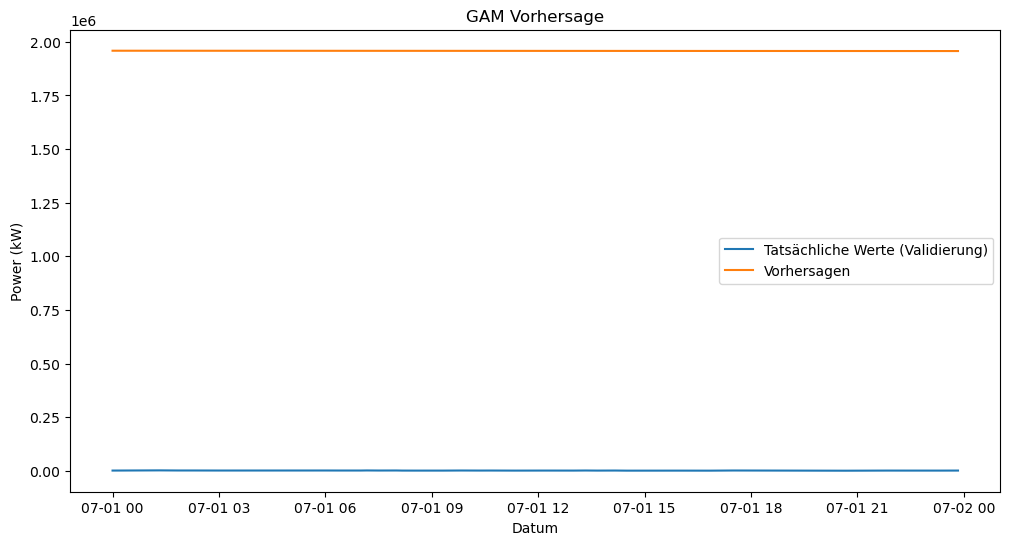

In [204]:
plt.figure(figsize=(12, 6))
plt.title("GAM Vorhersage")
plt.plot(df_val.index[:forecast_size], df_val["Power (kW)"].iloc[:forecast_size], label="Tatsächliche Werte (Validierung)")
plt.plot(df_val.index[:forecast_size], forecasts[:forecast_size], label="Vorhersagen")
plt.ylabel("Power (kW)")
plt.xlabel("Datum")
plt.legend()
plt.show()

# Prophet

In [61]:
df_prophet = df_train.reset_index()[["Date and time", "Power (kW)"]]
df_prophet.columns = ["ds", "y"]
df_prophet_val = df_val.reset_index()[["Date and time", "Power (kW)"]]
df_prophet_val.columns = ["ds", "y"]

In [62]:
df_prophet

,ds,y
0,2016-01-03 00:00:00,583.140015
1,2016-01-03 00:10:00,583.140015
2,2016-01-03 00:20:00,583.140015
3,2016-01-03 00:30:00,583.140015
4,2016-01-03 00:40:00,583.140015
...,...,...
89128,2019-06-30 22:40:00,544.928223
89129,2019-06-30 23:00:00,578.759598
89130,2019-06-30 23:20:00,779.790227
89131,2019-06-30 23:30:00,703.556299


In [63]:
train_size = 183600
forecast_size = 144

In [64]:
train_set = df_prophet.iloc[-train_size:]
val_set = df_prophet_val.iloc[:forecast_size]

In [65]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from hyperopt import fmin, tpe, hp, Trials

# Definiere das Ziel für die Optimierung
def objective(params):
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
    )
    model.fit(train_set)
    df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='365 days')
    df_p = performance_metrics(df_cv)
    return df_p['rmse'].mean()

# Suchraum definieren
space = {
    'changepoint_prior_scale': hp.loguniform('changepoint_prior_scale', -3, 0),
    'seasonality_prior_scale': hp.loguniform('seasonality_prior_scale', -3, 1),
}

# Optimierung durchführen
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
print("Beste Parameter:", best)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

21:31:47 - cmdstanpy - INFO - Chain [1] start processing

21:32:33 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

21:32:35 - cmdstanpy - INFO - Chain [1] start processing

21:32:39 - cmdstanpy - INFO - Chain [1] done processing

21:32:44 - cmdstanpy - INFO - Chain [1] start processing

21:33:07 - cmdstanpy - INFO - Chain [1] done processing

21:33:12 - cmdstanpy - INFO - Chain [1] start processing

21:33:26 - cmdstanpy - INFO - Chain [1] done processing

21:33:31 - cmdstanpy - INFO - Chain [1] start processing

21:33:51 - cmdstanpy - INFO - Chain [1] done processing



  2%|▏         | 1/50 [03:40<3:00:15, 220.73s/trial, best loss: 6439.282646894]

21:35:28 - cmdstanpy - INFO - Chain [1] start processing

21:35:51 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

21:35:53 - cmdstanpy - INFO - Chain [1] start processing

21:35:53 - cmdstanpy - INFO - Chain [1] done processing

21:35:58 - cmdstanpy - INFO - Chain [1] start processing

21:36:03 - cmdstanpy - INFO - Chain [1] done processing

21:36:08 - cmdstanpy - INFO - Chain [1] start processing

21:36:16 - cmdstanpy - INFO - Chain [1] done processing

21:36:22 - cmdstanpy - INFO - Chain [1] start processing

21:36:33 - cmdstanpy - INFO - Chain [1] done processing



  4%|▍         | 2/50 [06:23<2:29:06, 186.38s/trial, best loss: 854.3154867611671]

21:38:10 - cmdstanpy - INFO - Chain [1] start processing

21:38:48 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

21:38:49 - cmdstanpy - INFO - Chain [1] start processing

21:39:00 - cmdstanpy - INFO - Chain [1] done processing

21:39:04 - cmdstanpy - INFO - Chain [1] start processing

21:39:19 - cmdstanpy - INFO - Chain [1] done processing

21:39:24 - cmdstanpy - INFO - Chain [1] start processing

21:39:58 - cmdstanpy - INFO - Chain [1] done processing

21:40:03 - cmdstanpy - INFO - Chain [1] start processing

21:40:29 - cmdstanpy - INFO - Chain [1] done processing



  6%|▌         | 3/50 [10:19<2:43:52, 209.21s/trial, best loss: 854.3154867611671]

21:42:07 - cmdstanpy - INFO - Chain [1] start processing

21:42:37 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

21:42:39 - cmdstanpy - INFO - Chain [1] start processing

21:42:48 - cmdstanpy - INFO - Chain [1] done processing

21:42:52 - cmdstanpy - INFO - Chain [1] start processing

21:43:11 - cmdstanpy - INFO - Chain [1] done processing

21:43:16 - cmdstanpy - INFO - Chain [1] start processing

21:43:36 - cmdstanpy - INFO - Chain [1] done processing

21:43:41 - cmdstanpy - INFO - Chain [1] start processing

21:44:02 - cmdstanpy - INFO - Chain [1] done processing



  8%|▊         | 4/50 [13:50<2:41:06, 210.14s/trial, best loss: 854.3154867611671]

21:45:38 - cmdstanpy - INFO - Chain [1] start processing

21:46:16 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

21:46:18 - cmdstanpy - INFO - Chain [1] start processing

21:46:22 - cmdstanpy - INFO - Chain [1] done processing

21:46:26 - cmdstanpy - INFO - Chain [1] start processing

21:46:38 - cmdstanpy - INFO - Chain [1] done processing

21:46:43 - cmdstanpy - INFO - Chain [1] start processing

21:47:12 - cmdstanpy - INFO - Chain [1] done processing

21:47:18 - cmdstanpy - INFO - Chain [1] start processing

21:47:37 - cmdstanpy - INFO - Chain [1] done processing



 10%|█         | 5/50 [17:27<2:39:18, 212.40s/trial, best loss: 854.3154867611671]

21:49:15 - cmdstanpy - INFO - Chain [1] start processing

21:49:54 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

21:49:56 - cmdstanpy - INFO - Chain [1] start processing

21:50:06 - cmdstanpy - INFO - Chain [1] done processing

21:50:10 - cmdstanpy - INFO - Chain [1] start processing

21:50:20 - cmdstanpy - INFO - Chain [1] done processing

21:50:25 - cmdstanpy - INFO - Chain [1] start processing

21:50:45 - cmdstanpy - INFO - Chain [1] done processing

21:50:51 - cmdstanpy - INFO - Chain [1] start processing

21:51:19 - cmdstanpy - INFO - Chain [1] done processing



 12%|█▏        | 6/50 [21:10<2:38:24, 216.02s/trial, best loss: 854.3154867611671]

21:52:58 - cmdstanpy - INFO - Chain [1] start processing

21:53:20 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

21:53:22 - cmdstanpy - INFO - Chain [1] start processing

21:53:22 - cmdstanpy - INFO - Chain [1] done processing

21:53:27 - cmdstanpy - INFO - Chain [1] start processing

21:53:33 - cmdstanpy - INFO - Chain [1] done processing

21:53:39 - cmdstanpy - INFO - Chain [1] start processing

21:53:52 - cmdstanpy - INFO - Chain [1] done processing

21:53:58 - cmdstanpy - INFO - Chain [1] start processing

21:54:17 - cmdstanpy - INFO - Chain [1] done processing



 14%|█▍        | 7/50 [24:08<2:25:49, 203.48s/trial, best loss: 854.3154867611671]

21:55:55 - cmdstanpy - INFO - Chain [1] start processing

21:56:18 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

21:56:19 - cmdstanpy - INFO - Chain [1] start processing

21:56:20 - cmdstanpy - INFO - Chain [1] done processing

21:56:24 - cmdstanpy - INFO - Chain [1] start processing

21:56:29 - cmdstanpy - INFO - Chain [1] done processing

21:56:35 - cmdstanpy - INFO - Chain [1] start processing

21:56:47 - cmdstanpy - INFO - Chain [1] done processing

21:56:53 - cmdstanpy - INFO - Chain [1] start processing

21:57:07 - cmdstanpy - INFO - Chain [1] done processing



 16%|█▌        | 8/50 [26:58<2:15:04, 192.97s/trial, best loss: 854.3154867611671]

21:58:46 - cmdstanpy - INFO - Chain [1] start processing

21:59:14 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

21:59:16 - cmdstanpy - INFO - Chain [1] start processing

21:59:16 - cmdstanpy - INFO - Chain [1] done processing

21:59:21 - cmdstanpy - INFO - Chain [1] start processing

21:59:30 - cmdstanpy - INFO - Chain [1] done processing

21:59:35 - cmdstanpy - INFO - Chain [1] start processing

22:00:05 - cmdstanpy - INFO - Chain [1] done processing

22:00:11 - cmdstanpy - INFO - Chain [1] start processing

22:00:40 - cmdstanpy - INFO - Chain [1] done processing



 18%|█▊        | 9/50 [30:31<2:16:11, 199.31s/trial, best loss: 854.3154867611671]

22:02:19 - cmdstanpy - INFO - Chain [1] start processing

22:02:59 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:03:01 - cmdstanpy - INFO - Chain [1] start processing

22:03:04 - cmdstanpy - INFO - Chain [1] done processing

22:03:09 - cmdstanpy - INFO - Chain [1] start processing

22:03:21 - cmdstanpy - INFO - Chain [1] done processing

22:03:27 - cmdstanpy - INFO - Chain [1] start processing

22:03:54 - cmdstanpy - INFO - Chain [1] done processing

22:04:00 - cmdstanpy - INFO - Chain [1] start processing

22:04:38 - cmdstanpy - INFO - Chain [1] done processing



 20%|██        | 10/50 [34:35<2:21:54, 212.86s/trial, best loss: 854.3154867611671]

22:06:22 - cmdstanpy - INFO - Chain [1] start processing

22:06:38 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:06:40 - cmdstanpy - INFO - Chain [1] start processing

22:06:40 - cmdstanpy - INFO - Chain [1] done processing

22:06:45 - cmdstanpy - INFO - Chain [1] start processing

22:06:51 - cmdstanpy - INFO - Chain [1] done processing

22:06:56 - cmdstanpy - INFO - Chain [1] start processing

22:07:05 - cmdstanpy - INFO - Chain [1] done processing

22:07:11 - cmdstanpy - INFO - Chain [1] start processing

22:07:27 - cmdstanpy - INFO - Chain [1] done processing



 22%|██▏       | 11/50 [37:17<2:08:22, 197.51s/trial, best loss: 852.4179473012774]

22:09:05 - cmdstanpy - INFO - Chain [1] start processing

22:09:17 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:09:18 - cmdstanpy - INFO - Chain [1] start processing

22:09:19 - cmdstanpy - INFO - Chain [1] done processing

22:09:24 - cmdstanpy - INFO - Chain [1] start processing

22:09:30 - cmdstanpy - INFO - Chain [1] done processing

22:09:35 - cmdstanpy - INFO - Chain [1] start processing

22:09:47 - cmdstanpy - INFO - Chain [1] done processing

22:09:53 - cmdstanpy - INFO - Chain [1] start processing

22:10:08 - cmdstanpy - INFO - Chain [1] done processing



 24%|██▍       | 12/50 [39:57<1:57:46, 185.96s/trial, best loss: 852.4179473012774]

22:11:44 - cmdstanpy - INFO - Chain [1] start processing

22:12:21 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:12:23 - cmdstanpy - INFO - Chain [1] start processing

22:12:25 - cmdstanpy - INFO - Chain [1] done processing

22:12:30 - cmdstanpy - INFO - Chain [1] start processing

22:12:51 - cmdstanpy - INFO - Chain [1] done processing

22:12:56 - cmdstanpy - INFO - Chain [1] start processing

22:13:15 - cmdstanpy - INFO - Chain [1] done processing

22:13:21 - cmdstanpy - INFO - Chain [1] start processing

22:13:51 - cmdstanpy - INFO - Chain [1] done processing



 26%|██▌       | 13/50 [43:39<2:01:31, 197.08s/trial, best loss: 852.4179473012774]

22:15:27 - cmdstanpy - INFO - Chain [1] start processing

22:16:14 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:16:16 - cmdstanpy - INFO - Chain [1] start processing

22:16:18 - cmdstanpy - INFO - Chain [1] done processing

22:16:22 - cmdstanpy - INFO - Chain [1] start processing

22:16:34 - cmdstanpy - INFO - Chain [1] done processing

22:16:39 - cmdstanpy - INFO - Chain [1] start processing

22:17:02 - cmdstanpy - INFO - Chain [1] done processing

22:17:07 - cmdstanpy - INFO - Chain [1] start processing

22:17:38 - cmdstanpy - INFO - Chain [1] done processing



 28%|██▊       | 14/50 [47:28<2:03:51, 206.44s/trial, best loss: 852.4179473012774]

22:19:15 - cmdstanpy - INFO - Chain [1] start processing

22:19:58 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:20:00 - cmdstanpy - INFO - Chain [1] start processing

22:20:10 - cmdstanpy - INFO - Chain [1] done processing

22:20:15 - cmdstanpy - INFO - Chain [1] start processing

22:20:30 - cmdstanpy - INFO - Chain [1] done processing

22:20:35 - cmdstanpy - INFO - Chain [1] start processing

22:21:00 - cmdstanpy - INFO - Chain [1] done processing

22:21:06 - cmdstanpy - INFO - Chain [1] start processing

22:21:31 - cmdstanpy - INFO - Chain [1] done processing



 30%|███       | 15/50 [51:20<2:05:04, 214.42s/trial, best loss: 852.4179473012774]

22:23:08 - cmdstanpy - INFO - Chain [1] start processing

22:23:40 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:23:41 - cmdstanpy - INFO - Chain [1] start processing

22:23:42 - cmdstanpy - INFO - Chain [1] done processing

22:23:46 - cmdstanpy - INFO - Chain [1] start processing

22:24:00 - cmdstanpy - INFO - Chain [1] done processing

22:24:05 - cmdstanpy - INFO - Chain [1] start processing

22:24:34 - cmdstanpy - INFO - Chain [1] done processing

22:24:40 - cmdstanpy - INFO - Chain [1] start processing

22:24:59 - cmdstanpy - INFO - Chain [1] done processing



 32%|███▏      | 16/50 [54:48<2:00:23, 212.47s/trial, best loss: 852.4179473012774]

22:26:36 - cmdstanpy - INFO - Chain [1] start processing

22:27:11 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:27:12 - cmdstanpy - INFO - Chain [1] start processing

22:27:24 - cmdstanpy - INFO - Chain [1] done processing

22:27:29 - cmdstanpy - INFO - Chain [1] start processing

22:27:45 - cmdstanpy - INFO - Chain [1] done processing

22:27:50 - cmdstanpy - INFO - Chain [1] start processing

22:28:11 - cmdstanpy - INFO - Chain [1] done processing

22:28:17 - cmdstanpy - INFO - Chain [1] start processing

22:28:41 - cmdstanpy - INFO - Chain [1] done processing



 34%|███▍      | 17/50 [58:30<1:58:22, 215.23s/trial, best loss: 852.4179473012774]

22:30:18 - cmdstanpy - INFO - Chain [1] start processing

22:31:01 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:31:02 - cmdstanpy - INFO - Chain [1] start processing

22:31:08 - cmdstanpy - INFO - Chain [1] done processing

22:31:12 - cmdstanpy - INFO - Chain [1] start processing

22:31:30 - cmdstanpy - INFO - Chain [1] done processing

22:31:35 - cmdstanpy - INFO - Chain [1] start processing

22:32:01 - cmdstanpy - INFO - Chain [1] done processing

22:32:07 - cmdstanpy - INFO - Chain [1] start processing

22:32:20 - cmdstanpy - INFO - Chain [1] done processing



 36%|███▌      | 18/50 [1:02:08<1:55:18, 216.20s/trial, best loss: 852.4179473012774]

22:33:56 - cmdstanpy - INFO - Chain [1] start processing

22:34:34 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:34:36 - cmdstanpy - INFO - Chain [1] start processing

22:34:38 - cmdstanpy - INFO - Chain [1] done processing

22:34:42 - cmdstanpy - INFO - Chain [1] start processing

22:34:52 - cmdstanpy - INFO - Chain [1] done processing

22:34:57 - cmdstanpy - INFO - Chain [1] start processing

22:35:17 - cmdstanpy - INFO - Chain [1] done processing

22:35:22 - cmdstanpy - INFO - Chain [1] start processing

22:35:45 - cmdstanpy - INFO - Chain [1] done processing



 38%|███▊      | 19/50 [1:05:34<1:49:59, 212.88s/trial, best loss: 852.4179473012774]

22:37:21 - cmdstanpy - INFO - Chain [1] start processing

22:37:39 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:37:41 - cmdstanpy - INFO - Chain [1] start processing

22:37:53 - cmdstanpy - INFO - Chain [1] done processing

22:37:57 - cmdstanpy - INFO - Chain [1] start processing

22:38:21 - cmdstanpy - INFO - Chain [1] done processing

22:38:26 - cmdstanpy - INFO - Chain [1] start processing

22:38:50 - cmdstanpy - INFO - Chain [1] done processing

22:38:56 - cmdstanpy - INFO - Chain [1] start processing

22:39:15 - cmdstanpy - INFO - Chain [1] done processing



 40%|████      | 20/50 [1:09:04<1:46:02, 212.09s/trial, best loss: 852.4179473012774]

22:40:51 - cmdstanpy - INFO - Chain [1] start processing

22:41:30 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:41:31 - cmdstanpy - INFO - Chain [1] start processing

22:41:32 - cmdstanpy - INFO - Chain [1] done processing

22:41:36 - cmdstanpy - INFO - Chain [1] start processing

22:41:51 - cmdstanpy - INFO - Chain [1] done processing

22:41:56 - cmdstanpy - INFO - Chain [1] start processing

22:42:23 - cmdstanpy - INFO - Chain [1] done processing

22:42:29 - cmdstanpy - INFO - Chain [1] start processing

22:42:49 - cmdstanpy - INFO - Chain [1] done processing



 42%|████▏     | 21/50 [1:12:38<1:42:46, 212.64s/trial, best loss: 852.4179473012774]

22:44:25 - cmdstanpy - INFO - Chain [1] start processing

22:44:45 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:44:46 - cmdstanpy - INFO - Chain [1] start processing

22:44:47 - cmdstanpy - INFO - Chain [1] done processing

22:44:51 - cmdstanpy - INFO - Chain [1] start processing

22:44:55 - cmdstanpy - INFO - Chain [1] done processing

22:45:00 - cmdstanpy - INFO - Chain [1] start processing

22:45:09 - cmdstanpy - INFO - Chain [1] done processing

22:45:15 - cmdstanpy - INFO - Chain [1] start processing

22:45:33 - cmdstanpy - INFO - Chain [1] done processing



 44%|████▍     | 22/50 [1:15:22<1:32:23, 197.97s/trial, best loss: 852.4179473012774]

22:47:09 - cmdstanpy - INFO - Chain [1] start processing

22:47:39 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:47:40 - cmdstanpy - INFO - Chain [1] start processing

22:47:43 - cmdstanpy - INFO - Chain [1] done processing

22:47:47 - cmdstanpy - INFO - Chain [1] start processing

22:48:00 - cmdstanpy - INFO - Chain [1] done processing

22:48:05 - cmdstanpy - INFO - Chain [1] start processing

22:48:35 - cmdstanpy - INFO - Chain [1] done processing

22:48:40 - cmdstanpy - INFO - Chain [1] start processing

22:49:07 - cmdstanpy - INFO - Chain [1] done processing



 46%|████▌     | 23/50 [1:18:56<1:31:17, 202.87s/trial, best loss: 852.4179473012774]

22:50:43 - cmdstanpy - INFO - Chain [1] start processing

22:50:59 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:51:00 - cmdstanpy - INFO - Chain [1] start processing

22:51:00 - cmdstanpy - INFO - Chain [1] done processing

22:51:05 - cmdstanpy - INFO - Chain [1] start processing

22:51:14 - cmdstanpy - INFO - Chain [1] done processing

22:51:19 - cmdstanpy - INFO - Chain [1] start processing

22:51:35 - cmdstanpy - INFO - Chain [1] done processing

22:51:40 - cmdstanpy - INFO - Chain [1] start processing

22:52:02 - cmdstanpy - INFO - Chain [1] done processing



 48%|████▊     | 24/50 [1:21:51<1:24:20, 194.63s/trial, best loss: 852.4179473012774]

22:53:39 - cmdstanpy - INFO - Chain [1] start processing

22:53:58 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:54:00 - cmdstanpy - INFO - Chain [1] start processing

22:54:00 - cmdstanpy - INFO - Chain [1] done processing

22:54:05 - cmdstanpy - INFO - Chain [1] start processing

22:54:11 - cmdstanpy - INFO - Chain [1] done processing

22:54:16 - cmdstanpy - INFO - Chain [1] start processing

22:54:25 - cmdstanpy - INFO - Chain [1] done processing

22:54:30 - cmdstanpy - INFO - Chain [1] start processing

22:54:48 - cmdstanpy - INFO - Chain [1] done processing



 50%|█████     | 25/50 [1:24:38<1:17:34, 186.17s/trial, best loss: 852.4179473012774]

22:56:25 - cmdstanpy - INFO - Chain [1] start processing

22:56:57 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

22:56:58 - cmdstanpy - INFO - Chain [1] start processing

22:57:01 - cmdstanpy - INFO - Chain [1] done processing

22:57:06 - cmdstanpy - INFO - Chain [1] start processing

22:57:17 - cmdstanpy - INFO - Chain [1] done processing

22:57:22 - cmdstanpy - INFO - Chain [1] start processing

22:57:34 - cmdstanpy - INFO - Chain [1] done processing

22:57:39 - cmdstanpy - INFO - Chain [1] start processing

22:57:59 - cmdstanpy - INFO - Chain [1] done processing



 52%|█████▏    | 26/50 [1:27:48<1:14:57, 187.38s/trial, best loss: 852.4179473012774]

22:59:36 - cmdstanpy - INFO - Chain [1] start processing

23:00:00 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:00:01 - cmdstanpy - INFO - Chain [1] start processing

23:00:02 - cmdstanpy - INFO - Chain [1] done processing

23:00:06 - cmdstanpy - INFO - Chain [1] start processing

23:00:16 - cmdstanpy - INFO - Chain [1] done processing

23:00:21 - cmdstanpy - INFO - Chain [1] start processing

23:00:36 - cmdstanpy - INFO - Chain [1] done processing

23:00:42 - cmdstanpy - INFO - Chain [1] start processing

23:00:57 - cmdstanpy - INFO - Chain [1] done processing



 54%|█████▍    | 27/50 [1:30:47<1:10:53, 184.92s/trial, best loss: 852.4179473012774]

23:02:35 - cmdstanpy - INFO - Chain [1] start processing

23:03:18 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:03:19 - cmdstanpy - INFO - Chain [1] start processing

23:03:19 - cmdstanpy - INFO - Chain [1] done processing

23:03:24 - cmdstanpy - INFO - Chain [1] start processing

23:03:40 - cmdstanpy - INFO - Chain [1] done processing

23:03:45 - cmdstanpy - INFO - Chain [1] start processing

23:04:09 - cmdstanpy - INFO - Chain [1] done processing

23:04:15 - cmdstanpy - INFO - Chain [1] start processing

23:04:30 - cmdstanpy - INFO - Chain [1] done processing



 56%|█████▌    | 28/50 [1:34:18<1:10:42, 192.82s/trial, best loss: 852.4179473012774]

23:06:06 - cmdstanpy - INFO - Chain [1] start processing

23:06:37 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:06:39 - cmdstanpy - INFO - Chain [1] start processing

23:06:39 - cmdstanpy - INFO - Chain [1] done processing

23:06:44 - cmdstanpy - INFO - Chain [1] start processing

23:06:58 - cmdstanpy - INFO - Chain [1] done processing

23:07:03 - cmdstanpy - INFO - Chain [1] start processing

23:07:23 - cmdstanpy - INFO - Chain [1] done processing

23:07:29 - cmdstanpy - INFO - Chain [1] start processing

23:07:54 - cmdstanpy - INFO - Chain [1] done processing



 58%|█████▊    | 29/50 [1:37:42<1:08:39, 196.15s/trial, best loss: 852.4179473012774]

23:09:30 - cmdstanpy - INFO - Chain [1] start processing

23:10:02 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:10:04 - cmdstanpy - INFO - Chain [1] start processing

23:10:14 - cmdstanpy - INFO - Chain [1] done processing

23:10:18 - cmdstanpy - INFO - Chain [1] start processing

23:10:37 - cmdstanpy - INFO - Chain [1] done processing

23:10:42 - cmdstanpy - INFO - Chain [1] start processing

23:10:59 - cmdstanpy - INFO - Chain [1] done processing

23:11:05 - cmdstanpy - INFO - Chain [1] start processing

23:11:24 - cmdstanpy - INFO - Chain [1] done processing



 60%|██████    | 30/50 [1:41:13<1:06:50, 200.51s/trial, best loss: 852.4179473012774]

23:13:01 - cmdstanpy - INFO - Chain [1] start processing

23:13:30 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:13:31 - cmdstanpy - INFO - Chain [1] start processing

23:13:32 - cmdstanpy - INFO - Chain [1] done processing

23:13:36 - cmdstanpy - INFO - Chain [1] start processing

23:13:43 - cmdstanpy - INFO - Chain [1] done processing

23:13:48 - cmdstanpy - INFO - Chain [1] start processing

23:14:00 - cmdstanpy - INFO - Chain [1] done processing

23:14:05 - cmdstanpy - INFO - Chain [1] start processing

23:14:18 - cmdstanpy - INFO - Chain [1] done processing



 62%|██████▏   | 31/50 [1:44:06<1:00:55, 192.37s/trial, best loss: 852.4179473012774]

23:15:54 - cmdstanpy - INFO - Chain [1] start processing

23:16:12 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:16:13 - cmdstanpy - INFO - Chain [1] start processing

23:16:14 - cmdstanpy - INFO - Chain [1] done processing

23:16:18 - cmdstanpy - INFO - Chain [1] start processing

23:16:25 - cmdstanpy - INFO - Chain [1] done processing

23:16:30 - cmdstanpy - INFO - Chain [1] start processing

23:16:49 - cmdstanpy - INFO - Chain [1] done processing

23:16:54 - cmdstanpy - INFO - Chain [1] start processing

23:17:17 - cmdstanpy - INFO - Chain [1] done processing



 64%|██████▍   | 32/50 [1:47:06<56:32, 188.47s/trial, best loss: 852.4179473012774]  

23:18:53 - cmdstanpy - INFO - Chain [1] start processing

23:19:28 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:19:30 - cmdstanpy - INFO - Chain [1] start processing

23:19:35 - cmdstanpy - INFO - Chain [1] done processing

23:19:39 - cmdstanpy - INFO - Chain [1] start processing

23:20:02 - cmdstanpy - INFO - Chain [1] done processing

23:20:07 - cmdstanpy - INFO - Chain [1] start processing

23:20:27 - cmdstanpy - INFO - Chain [1] done processing

23:20:32 - cmdstanpy - INFO - Chain [1] start processing

23:20:58 - cmdstanpy - INFO - Chain [1] done processing



 66%|██████▌   | 33/50 [1:50:47<56:13, 198.42s/trial, best loss: 852.4179473012774]

23:22:35 - cmdstanpy - INFO - Chain [1] start processing

23:22:59 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:23:00 - cmdstanpy - INFO - Chain [1] start processing

23:23:01 - cmdstanpy - INFO - Chain [1] done processing

23:23:05 - cmdstanpy - INFO - Chain [1] start processing

23:23:14 - cmdstanpy - INFO - Chain [1] done processing

23:23:19 - cmdstanpy - INFO - Chain [1] start processing

23:23:42 - cmdstanpy - INFO - Chain [1] done processing

23:23:48 - cmdstanpy - INFO - Chain [1] start processing

23:24:09 - cmdstanpy - INFO - Chain [1] done processing



 68%|██████▊   | 34/50 [1:53:58<52:16, 196.04s/trial, best loss: 852.4179473012774]

23:25:45 - cmdstanpy - INFO - Chain [1] start processing

23:26:27 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:26:28 - cmdstanpy - INFO - Chain [1] start processing

23:26:32 - cmdstanpy - INFO - Chain [1] done processing

23:26:37 - cmdstanpy - INFO - Chain [1] start processing

23:26:46 - cmdstanpy - INFO - Chain [1] done processing

23:26:51 - cmdstanpy - INFO - Chain [1] start processing

23:27:14 - cmdstanpy - INFO - Chain [1] done processing

23:27:19 - cmdstanpy - INFO - Chain [1] start processing

23:27:43 - cmdstanpy - INFO - Chain [1] done processing



 70%|███████   | 35/50 [1:57:32<50:20, 201.34s/trial, best loss: 852.4179473012774]

23:29:19 - cmdstanpy - INFO - Chain [1] start processing

23:29:42 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:29:44 - cmdstanpy - INFO - Chain [1] start processing

23:29:44 - cmdstanpy - INFO - Chain [1] done processing

23:29:49 - cmdstanpy - INFO - Chain [1] start processing

23:29:56 - cmdstanpy - INFO - Chain [1] done processing

23:30:01 - cmdstanpy - INFO - Chain [1] start processing

23:30:13 - cmdstanpy - INFO - Chain [1] done processing

23:30:18 - cmdstanpy - INFO - Chain [1] start processing

23:30:34 - cmdstanpy - INFO - Chain [1] done processing



 72%|███████▏  | 36/50 [2:00:24<44:55, 192.53s/trial, best loss: 852.4179473012774]

23:32:11 - cmdstanpy - INFO - Chain [1] start processing

23:32:32 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:32:33 - cmdstanpy - INFO - Chain [1] start processing

23:32:34 - cmdstanpy - INFO - Chain [1] done processing

23:32:38 - cmdstanpy - INFO - Chain [1] start processing

23:32:43 - cmdstanpy - INFO - Chain [1] done processing

23:32:48 - cmdstanpy - INFO - Chain [1] start processing

23:32:57 - cmdstanpy - INFO - Chain [1] done processing

23:33:03 - cmdstanpy - INFO - Chain [1] start processing

23:33:13 - cmdstanpy - INFO - Chain [1] done processing



 74%|███████▍  | 37/50 [2:03:03<39:32, 182.52s/trial, best loss: 852.4179473012774]

23:34:50 - cmdstanpy - INFO - Chain [1] start processing

23:35:26 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:35:27 - cmdstanpy - INFO - Chain [1] start processing

23:35:35 - cmdstanpy - INFO - Chain [1] done processing

23:35:40 - cmdstanpy - INFO - Chain [1] start processing

23:35:58 - cmdstanpy - INFO - Chain [1] done processing

23:36:03 - cmdstanpy - INFO - Chain [1] start processing

23:36:29 - cmdstanpy - INFO - Chain [1] done processing

23:36:35 - cmdstanpy - INFO - Chain [1] start processing

23:37:00 - cmdstanpy - INFO - Chain [1] done processing



 76%|███████▌  | 38/50 [2:06:49<39:07, 195.67s/trial, best loss: 852.4179473012774]

23:38:37 - cmdstanpy - INFO - Chain [1] start processing

23:39:15 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:39:16 - cmdstanpy - INFO - Chain [1] start processing

23:39:17 - cmdstanpy - INFO - Chain [1] done processing

23:39:21 - cmdstanpy - INFO - Chain [1] start processing

23:39:39 - cmdstanpy - INFO - Chain [1] done processing

23:39:44 - cmdstanpy - INFO - Chain [1] start processing

23:40:06 - cmdstanpy - INFO - Chain [1] done processing

23:40:12 - cmdstanpy - INFO - Chain [1] start processing

23:40:32 - cmdstanpy - INFO - Chain [1] done processing



 78%|███████▊  | 39/50 [2:10:21<36:46, 200.56s/trial, best loss: 852.4179473012774]

23:42:09 - cmdstanpy - INFO - Chain [1] start processing

23:42:42 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:42:43 - cmdstanpy - INFO - Chain [1] start processing

23:42:44 - cmdstanpy - INFO - Chain [1] done processing

23:42:48 - cmdstanpy - INFO - Chain [1] start processing

23:42:55 - cmdstanpy - INFO - Chain [1] done processing

23:43:00 - cmdstanpy - INFO - Chain [1] start processing

23:43:18 - cmdstanpy - INFO - Chain [1] done processing

23:43:23 - cmdstanpy - INFO - Chain [1] start processing

23:43:45 - cmdstanpy - INFO - Chain [1] done processing



 80%|████████  | 40/50 [2:13:35<33:04, 198.48s/trial, best loss: 852.4179473012774]

23:45:22 - cmdstanpy - INFO - Chain [1] start processing

23:45:57 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:45:59 - cmdstanpy - INFO - Chain [1] start processing

23:46:09 - cmdstanpy - INFO - Chain [1] done processing

23:46:14 - cmdstanpy - INFO - Chain [1] start processing

23:46:31 - cmdstanpy - INFO - Chain [1] done processing

23:46:36 - cmdstanpy - INFO - Chain [1] start processing

23:47:01 - cmdstanpy - INFO - Chain [1] done processing

23:47:07 - cmdstanpy - INFO - Chain [1] start processing

23:47:32 - cmdstanpy - INFO - Chain [1] done processing



 82%|████████▏ | 41/50 [2:17:21<31:02, 206.89s/trial, best loss: 852.4179473012774]

23:49:09 - cmdstanpy - INFO - Chain [1] start processing

23:49:47 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:49:48 - cmdstanpy - INFO - Chain [1] start processing

23:49:51 - cmdstanpy - INFO - Chain [1] done processing

23:49:56 - cmdstanpy - INFO - Chain [1] start processing

23:50:11 - cmdstanpy - INFO - Chain [1] done processing

23:50:16 - cmdstanpy - INFO - Chain [1] start processing

23:50:46 - cmdstanpy - INFO - Chain [1] done processing

23:50:51 - cmdstanpy - INFO - Chain [1] start processing

23:51:14 - cmdstanpy - INFO - Chain [1] done processing



 84%|████████▍ | 42/50 [2:21:03<28:12, 211.51s/trial, best loss: 852.4179473012774]

23:52:51 - cmdstanpy - INFO - Chain [1] start processing

23:53:41 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:53:43 - cmdstanpy - INFO - Chain [1] start processing

23:53:53 - cmdstanpy - INFO - Chain [1] done processing

23:53:57 - cmdstanpy - INFO - Chain [1] start processing

23:54:14 - cmdstanpy - INFO - Chain [1] done processing

23:54:19 - cmdstanpy - INFO - Chain [1] start processing

23:54:47 - cmdstanpy - INFO - Chain [1] done processing

23:54:53 - cmdstanpy - INFO - Chain [1] start processing

23:55:13 - cmdstanpy - INFO - Chain [1] done processing



 86%|████████▌ | 43/50 [2:25:03<25:38, 219.82s/trial, best loss: 852.4179473012774]

23:56:50 - cmdstanpy - INFO - Chain [1] start processing

23:57:16 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

23:57:17 - cmdstanpy - INFO - Chain [1] start processing

23:57:18 - cmdstanpy - INFO - Chain [1] done processing

23:57:22 - cmdstanpy - INFO - Chain [1] start processing

23:57:29 - cmdstanpy - INFO - Chain [1] done processing

23:57:34 - cmdstanpy - INFO - Chain [1] start processing

23:57:48 - cmdstanpy - INFO - Chain [1] done processing

23:57:54 - cmdstanpy - INFO - Chain [1] start processing

23:58:06 - cmdstanpy - INFO - Chain [1] done processing



 88%|████████▊ | 44/50 [2:27:55<20:33, 205.56s/trial, best loss: 852.4179473012774]

23:59:42 - cmdstanpy - INFO - Chain [1] start processing

00:00:10 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

00:00:11 - cmdstanpy - INFO - Chain [1] start processing

00:00:12 - cmdstanpy - INFO - Chain [1] done processing

00:00:16 - cmdstanpy - INFO - Chain [1] start processing

00:00:22 - cmdstanpy - INFO - Chain [1] done processing

00:00:27 - cmdstanpy - INFO - Chain [1] start processing

00:00:46 - cmdstanpy - INFO - Chain [1] done processing

00:00:52 - cmdstanpy - INFO - Chain [1] start processing

00:01:07 - cmdstanpy - INFO - Chain [1] done processing



 90%|█████████ | 45/50 [2:30:56<16:30, 198.17s/trial, best loss: 852.4179473012774]

00:02:43 - cmdstanpy - INFO - Chain [1] start processing

00:03:13 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

00:03:14 - cmdstanpy - INFO - Chain [1] start processing

00:03:15 - cmdstanpy - INFO - Chain [1] done processing

00:03:19 - cmdstanpy - INFO - Chain [1] start processing

00:03:29 - cmdstanpy - INFO - Chain [1] done processing

00:03:34 - cmdstanpy - INFO - Chain [1] start processing

00:04:08 - cmdstanpy - INFO - Chain [1] done processing

00:04:13 - cmdstanpy - INFO - Chain [1] start processing

00:04:33 - cmdstanpy - INFO - Chain [1] done processing



 92%|█████████▏| 46/50 [2:34:22<13:22, 200.61s/trial, best loss: 852.4179473012774]

00:06:10 - cmdstanpy - INFO - Chain [1] start processing

00:06:51 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

00:06:53 - cmdstanpy - INFO - Chain [1] start processing

00:07:01 - cmdstanpy - INFO - Chain [1] done processing

00:07:06 - cmdstanpy - INFO - Chain [1] start processing

00:07:21 - cmdstanpy - INFO - Chain [1] done processing

00:07:26 - cmdstanpy - INFO - Chain [1] start processing

00:07:46 - cmdstanpy - INFO - Chain [1] done processing

00:07:52 - cmdstanpy - INFO - Chain [1] start processing

00:08:20 - cmdstanpy - INFO - Chain [1] done processing



 94%|█████████▍| 47/50 [2:38:09<10:25, 208.41s/trial, best loss: 852.4179473012774]

00:09:56 - cmdstanpy - INFO - Chain [1] start processing

00:10:33 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

00:10:35 - cmdstanpy - INFO - Chain [1] start processing

00:10:35 - cmdstanpy - INFO - Chain [1] done processing

00:10:40 - cmdstanpy - INFO - Chain [1] start processing

00:10:49 - cmdstanpy - INFO - Chain [1] done processing

00:10:54 - cmdstanpy - INFO - Chain [1] start processing

00:11:25 - cmdstanpy - INFO - Chain [1] done processing

00:11:30 - cmdstanpy - INFO - Chain [1] start processing

00:11:52 - cmdstanpy - INFO - Chain [1] done processing



 96%|█████████▌| 48/50 [2:41:41<06:59, 209.51s/trial, best loss: 852.4179473012774]

00:13:28 - cmdstanpy - INFO - Chain [1] start processing

00:13:51 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

00:13:52 - cmdstanpy - INFO - Chain [1] start processing

00:13:52 - cmdstanpy - INFO - Chain [1] done processing

00:13:57 - cmdstanpy - INFO - Chain [1] start processing

00:14:02 - cmdstanpy - INFO - Chain [1] done processing

00:14:07 - cmdstanpy - INFO - Chain [1] start processing

00:14:18 - cmdstanpy - INFO - Chain [1] done processing

00:14:23 - cmdstanpy - INFO - Chain [1] start processing

00:14:38 - cmdstanpy - INFO - Chain [1] done processing



 98%|█████████▊| 49/50 [2:44:27<03:16, 196.41s/trial, best loss: 852.4179473012774]

00:16:14 - cmdstanpy - INFO - Chain [1] start processing

00:16:41 - cmdstanpy - INFO - Chain [1] done processing

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



  0%|          | 0/4 [00:00<?, ?it/s]

00:16:43 - cmdstanpy - INFO - Chain [1] start processing

00:16:43 - cmdstanpy - INFO - Chain [1] done processing

00:16:48 - cmdstanpy - INFO - Chain [1] start processing

00:17:00 - cmdstanpy - INFO - Chain [1] done processing

00:17:05 - cmdstanpy - INFO - Chain [1] start processing

00:17:36 - cmdstanpy - INFO - Chain [1] done processing

00:17:42 - cmdstanpy - INFO - Chain [1] start processing

00:18:00 - cmdstanpy - INFO - Chain [1] done processing



100%|██████████| 50/50 [2:47:49<00:00, 201.39s/trial, best loss: 852.4179473012774]
Beste Parameter: {'changepoint_prior_scale': 0.05320279190062062, 'seasonality_prior_scale': 0.5415202425966086}


In [76]:
from prophet import Prophet

prophet = Prophet(
    changepoint_prior_scale=0.5,
    weekly_seasonality=True,
    daily_seasonality=True,
    yearly_seasonality=True
)

In [77]:
prophet.fit(train_set)

17:06:09 - cmdstanpy - INFO - Chain [1] start processing

17:06:35 - cmdstanpy - INFO - Chain [1] done processing



In [78]:
future = prophet.make_future_dataframe(periods=1, freq="10T")

In [79]:
future

,ds
0,2016-01-03 00:00:00
1,2016-01-03 00:10:00
2,2016-01-03 00:20:00
3,2016-01-03 00:30:00
4,2016-01-03 00:40:00
...,...
89129,2019-06-30 23:00:00
89130,2019-06-30 23:20:00
89131,2019-06-30 23:30:00
89132,2019-06-30 23:40:00


In [80]:
forecast = prophet.predict(future)

In [81]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-03 00:00:00,737.262761,14.106124,1347.883830,737.262761,737.262761,-83.177273,-83.177273,-83.177273,15.586074,...,-0.637847,-0.637847,-0.637847,-98.125500,-98.125500,-98.125500,0.0,0.0,0.0,654.085488
1,2016-01-03 00:10:00,737.315402,3.793518,1324.098004,737.315402,737.315402,-83.982612,-83.982612,-83.982612,15.053679,...,-0.849525,-0.849525,-0.849525,-98.186766,-98.186766,-98.186766,0.0,0.0,0.0,653.332790
2,2016-01-03 00:20:00,737.368043,-13.271364,1313.667254,737.368043,737.368043,-84.960053,-84.960053,-84.960053,14.348575,...,-1.060543,-1.060543,-1.060543,-98.248085,-98.248085,-98.248085,0.0,0.0,0.0,652.407990
3,2016-01-03 00:30:00,737.420684,9.224487,1372.161245,737.420684,737.420684,-86.086865,-86.086865,-86.086865,13.493434,...,-1.270842,-1.270842,-1.270842,-98.309457,-98.309457,-98.309457,0.0,0.0,0.0,651.333820
4,2016-01-03 00:40:00,737.473325,-61.539807,1369.851375,737.473325,737.473325,-87.335394,-87.335394,-87.335394,12.515847,...,-1.480360,-1.480360,-1.480360,-98.370881,-98.370881,-98.370881,0.0,0.0,0.0,650.137931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89129,2019-06-30 23:00:00,321.332007,-319.303222,1100.790380,321.332007,321.332007,86.521078,86.521078,86.521078,14.610911,...,-12.027889,-12.027889,-12.027889,83.938055,83.938055,83.938055,0.0,0.0,0.0,407.853085
89130,2019-06-30 23:20:00,321.293322,-271.197355,1112.481751,321.293322,321.293322,87.644879,87.644879,87.644879,15.734681,...,-11.991415,-11.991415,-11.991415,83.901613,83.901613,83.901613,0.0,0.0,0.0,408.938201
89131,2019-06-30 23:30:00,321.273980,-291.241822,1117.091888,321.273980,321.273980,87.914600,87.914600,87.914600,16.005012,...,-11.973749,-11.973749,-11.973749,83.883336,83.883336,83.883336,0.0,0.0,0.0,409.188579
89132,2019-06-30 23:40:00,321.254637,-305.515337,1097.934413,321.254637,321.254637,87.978453,87.978453,87.978453,16.069962,...,-11.956532,-11.956532,-11.956532,83.865023,83.865023,83.865023,0.0,0.0,0.0,409.233090


In [82]:
actuals = val_set['y']
predictions = forecast['yhat'].iloc[-len(val_set):]

prophet_mse = mean_squared_error(actuals, predictions)
prophet_mae = mean_absolute_error(actuals, predictions)
prophet_rmse = root_mean_squared_error(actuals, predictions)

print(f'Mean Squared Error: {prophet_mse}')
print(f'Mean Absolute Error: {prophet_mae}')
print(f'Root Mean Squared Error: {prophet_rmse}')

Mean Squared Error: 201607.37938869456
Mean Absolute Error: 373.8760329590433
Root Mean Squared Error: 449.00710394012094


In [83]:
predictions

88990    429.931406
88991    431.329566
88992    432.632053
88993    434.839918
88994    435.697875
            ...    
89129    407.853085
89130    408.938201
89131    409.188579
89132    409.233090
89133    409.070744
Name: yhat, Length: 144, dtype: float64

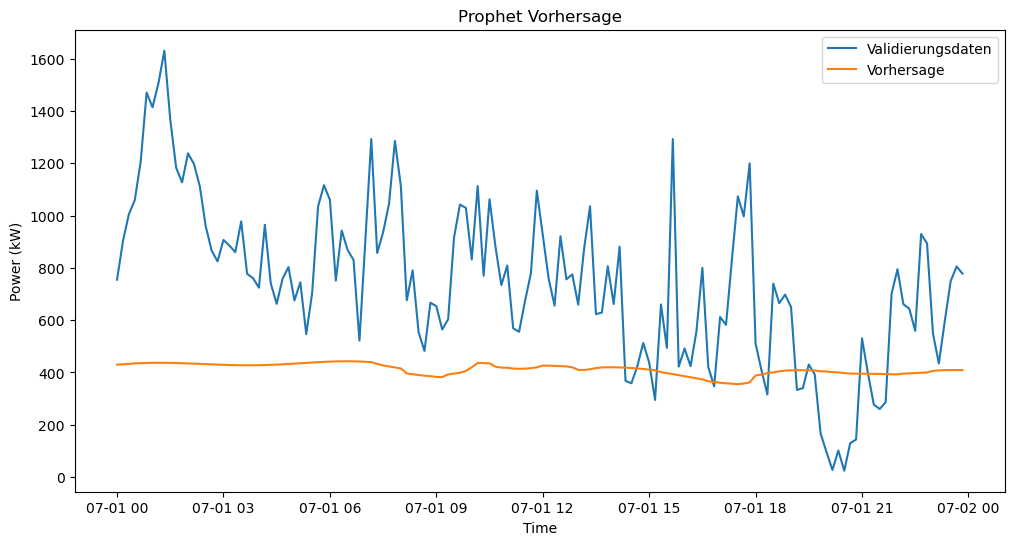

In [84]:
plt.figure(figsize=(12, 6))
plt.title(label="Prophet Vorhersage")
plt.plot(val_set['ds'].iloc[:144], val_set['y'].iloc[:144], label="Validierungsdaten")
plt.plot(val_set['ds'].iloc[:144], predictions.iloc[:144], label="Vorhersage")
plt.ylabel("Power (kW)")
plt.xlabel("Time")
plt.legend()
plt.show()